# Hybrid Indices Report (DEJD Variations)

#### Report Date : 30 Aug 2024



## Product Information

Product Specification : https://docs.google.com/spreadsheets/d/13ppWafDpjXYBNgWxm9WejV2oxwoQHRv2DVsyBZRbhjw/edit?gid=427402466#gid=427402466

Demo Launch: 26 August 2024 3:29pm GMT+8 (7:29am UTC)

### <u>Background & Introduction</u>

The Hybrid indices are DEX versions of the Crash/Boom indices. These indices will look a little better, since in between jumps, its a vol index, and be much more well-behaved for option pricing. The two types of Hybrid Indices are Vol-and-Crash and Vol-and-Boom.

### Index Construction

For information about the index construction, please refer to the Double Exponential (DEX) Index Validation Report as of 22 May 2023 ([link](https://github.com/regentmarkets/quants-model-validation/blob/master/Validation/Feeds/Double%20Exponential%20Jump%20Index/1.%20First%20Launch%20(DEX%20900)/Dex%20Indices%20Validation%20Report.pdf)).

The following is a summary of the construction 

#### DEX (DEJD)

Recall that DEX is given as 

$$
S_t = S_{t-1} \exp \left[ \left(r - d - \frac{\sigma^2}{2} - \lambda \alpha \right) dt + \sigma \sqrt{dt} W + \sum_{i=1}^{N(\lambda dt)} J_i \right]
$$

Where:

* $S$ - Spot;
* $r$ - Risk-free rate;
* $d$ - Dividend rate;
* $N$ - Poisson process with intensity (mean) $\lambda$, that is $P(N(\lambda) = k) = \frac{\lambda^ke^{-\lambda}}{k!}$;
* $\lambda$ - Expected of number of jumps per annum;
* $J$ - Random jump size with the double exponential distribution as detailed below;
* $\alpha$ - The drift correction from the jump terms, i.e $E(e^J - 1)$;
* $\sigma$ - Volatility;
* $W$ - A normally distributed random sample.

The density of $J$ (double exponential distribution) is given as:

$$
w(J) = \frac{q_-}{\eta_-}e^{\frac{J}{\eta_-}} \mathbf{1}_{J<0} + \frac{q_+}{\eta_+}e^{-\frac{J}{\eta_+}} \mathbf{1}_{J \geq 0}
$$

Where:

* $\mathbf{1}$ is the indicator function;
* $q_{\pm}$ - The probability of a positive/negative jump ($q_- + q_+ = 1$);
* $\eta_{\pm}$ - The expected size of a positive/negative jump.



### Defining Vol over CB
For these indices, we modify the jump distribution to get a one-sided distribution, by setting one of $q_{\pm} = 0$. We will have two types of indices:

#### Vol-and-Crash
We set $q_{+} = \eta_{+} = 0$, and $q_{-} = 1$, $\eta_{-} > 0$:

$$
w(J) = \frac{1}{\eta_-}e^{\frac{J}{\eta_-}} \mathbf{1}_{J<0}
$$

#### Vol-and-Boom
We set $q_{-} = \eta_{-} = 0$, and $q_{+} = 1$, $\eta_{+} > 0$:

$$
w(J) = \frac{1}{\eta_+}e^{-\frac{J}{\eta_+}} \mathbf{1}_{J \geq 0}
$$

## Parameters

|Index|Number of Jumps per Hour $\lambda$|Average Positive Jump Size $\eta_{+}$|Average Negative Jump Size $\eta_{-}$|Probability of Positive Jump $q_{+}$|Probability of Negative Jump $q_{-}$|Volatility|Percentage Spread|
|--|--|--|--|--|--|--|--|
|Vol-and-Crash 400|9, which is 78840 per year|0.00%|0.20%|0%|100%|20%|0.01%|
|Vol-and-Crash 550|6.55, which is about 57338 per year|0.00%|0.20%|0%|100%|20%|0.01%|
|Vol-and-Crash 750|4.8, which is 42048 per year|0.00%|0.20%|0%|100%|20%|0.01%|
|Vol-and-Boom 400|9, which is 78840 per year|0.20%|0.00%|100%|0%|20%|0.01%|
|Vol-and-Boom 550|6.55, which is about 57338 per year|0.20%|0.00%|100%|0%|20%|0.01%|
|Vol-and-Boom 750|4.8, which is 42048 per year|0.20%|0.00%|100%|0%|20%|0.01%|




## Model Validation

### Summary

For the validation of the Hybrid indices, we cover the below areas and conclude the outcomes.

Note that this validation covers the data from 20 August 2024 to 29 August 2024.

This index was released on Demo at 26 August 2024.

More details can be found in respective section.

|Section|Area|Validation|Outcome|Pass/Fail|
|-|-|-|-|-|
|1|Check the moment of the feed data|We compute the moment of the feed data, and check whether it is matching with the true distribution.|We checked the moments of the feed data vs simulation for 3 sets of data, Dev data only, Demo data only and Dev + Demo data. <br> The moments are match up to acceptable margins. |<b>Passed</b>|
|2|Backward engineering the parameters.| Here we check the parameters backward engineering from the feed data moment. We do not proceed with the MLE method as the implementation is very difficult to implement| The result looks good with set initial condition and boundary condition, even with only 9 days of data.|<b>Passed</b>|
|3|Convergence of the feed data moment| The convergence speed of the first 3 moments are checked.|The moments have not converged fully yet, but are closed. Similar tests with the DEX indices suggest it will converge with 2 weeks+ of data|<b>Passed</b>|
|4|Concentration Risk Stress Testing| Few strategy testings on simulation data is run to ensure that there is no potential exploitation and the reasonableness of the spread.| The strategy testing does not discover any potential exploitation. The strategy testing result also shows that the Product Quants suggested spreads cover this strategy very well, as the returns are very low.|<b>Passed</b>|
|5|Correlation between variations| This is to test the pairwise correlations, which should be almost zero| Correlations between tickly data and hourly data do not have significantly high correlation.|<b>Passed</b>|


In [76]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.stats import norm,skew,kurtosis,poisson
from scipy.optimize import minimize,fsolve
from IPython.display import display_html
from itertools import chain,cycle
import numba as nb
from math import factorial

from alive_progress import alive_bar  

In [77]:
def mgf_jump(q,eta_p,eta_n,t=0):
    return q/(1-t*eta_p)+(1-q)/(1+t*eta_n)

def inv_J_cdf_mv(cdf,q,eta_p,eta_n):
    if cdf<1-q:
        return eta_n*np.log(cdf/(1-q))
    else:
        return -eta_p*np.log((1-cdf)/(q))
    

def inv_J_cdf_perl(cdf,q,eta_p,eta_n):
    n = np.random.uniform()
    if cdf<q:
        return -(eta_p*np.log(1-n))
        
    # Negative jump
    else:
        return eta_n*np.log(1-n)

### Section 1

In here we are checking the moments of the real feed data. The validation steps are:
1) Obtain the feed data from Metabase. 
2) Compute the feed data moments (Mean, Volatility, Skewness & Kurtosis).
3) Run the simulation and compute the moments.
4) Compare (2) & (3)

Conclusion:
1) Mean - Acceptable as the abs difference is low.
2) Volatility - Acceptable as both abs and rel difference are low.
3) Skewness - Acceptable as rel difference is low.
4) Kurtosis - Acceptable.

In [78]:
def data_massage(df):
    df['ts'] = pd.to_datetime(df['ts'])
    df.sort_values('ts',inplace=True)
    df['return'] = np.log(df['spot']/df['spot'].shift(1))
    df['5_min_return'] = np.log(df['spot']/df['spot'].shift(60*5))
    df['hourly_return'] = np.log(df['spot']/df['spot'].shift(3600))
    df['moment_1'] = (df['spot']/df['spot'].shift(1))**2
    df['moment_2'] = (df['spot']/df['spot'].shift(1))**2
    df['moment_3'] = (df['spot']/df['spot'].shift(1))**3
    df['moment_4'] = (df['spot']/df['spot'].shift(1))**4
    df['moment_5'] = (df['spot']/df['spot'].shift(1))**5
    df['moment_6'] = (df['spot']/df['spot'].shift(1))**6

    df['spread_perct'] = (df['ask']-df['bid'])/ df['spot']

    df = df.tail(-1)

    return df

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:top"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: top;"><font size="-1">{title}</font></h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)


dex_VolCrash400 = data_massage(pd.read_csv('./csv/VOLCRASH400_prod.csv'))
dex_VolCrash550 = data_massage(pd.read_csv('./csv/VOLCRASH550_prod.csv'))
dex_VolCrash750 = data_massage(pd.read_csv('./csv/VOLCRASH750_prod.csv'))
dex_VolBoom400 = data_massage(pd.read_csv('./csv/VOLBOOM400_prod.csv'))
dex_VolBoom550 = data_massage(pd.read_csv('./csv/VOLBOOM550_prod.csv'))
dex_VolBoom750 = data_massage(pd.read_csv('./csv/VOLBOOM750_prod.csv'))


dex_VolCrash = [dex_VolCrash400,dex_VolCrash550,dex_VolCrash750]
dex_VolBoom =  [dex_VolBoom400,dex_VolBoom550,dex_VolBoom750]
dex_VolCrash_name = ['VolCrash400', 'VolCrash550', 'VolCrash750', ]
dex_VolBoom_name = ['VolBoom400', 'VolBoom550', 'VolBoom750']

dex_VolCrash_dict = dict(zip(dex_VolCrash_name, dex_VolCrash))
dex_VolBoom_dict = dict(zip(dex_VolBoom_name, dex_VolBoom))
dex_VolCrashBoom_dict = dex_VolCrash_dict | dex_VolBoom_dict

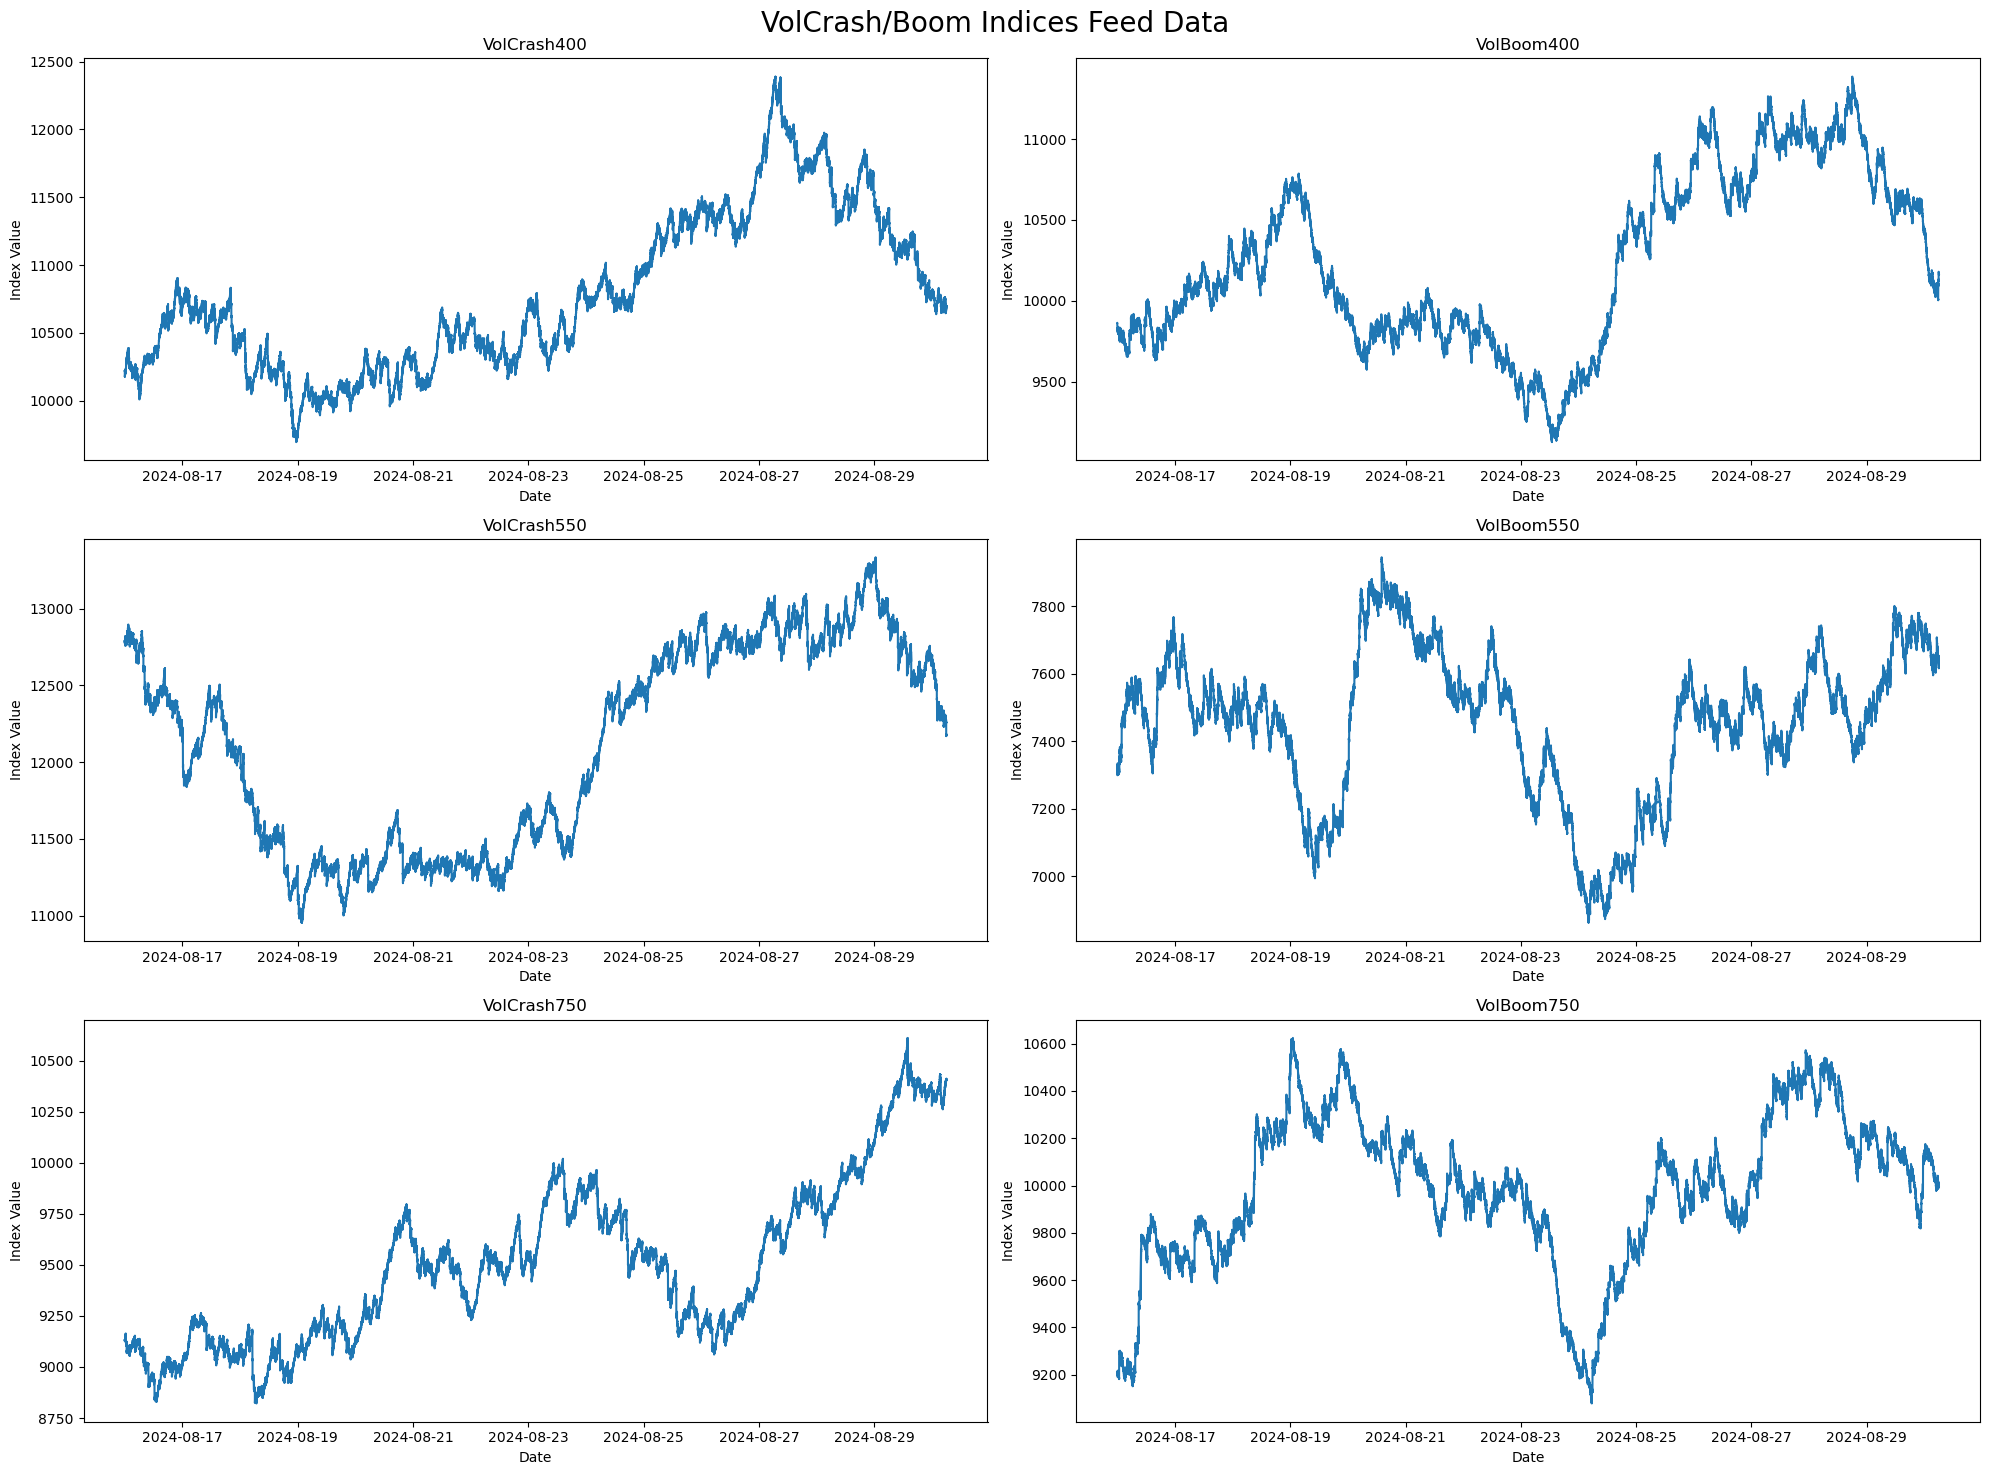

In [79]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(20,15))

for i in range(len(dex_VolCrash)):

    dex_c = dex_VolCrash[i]
    dex_b = dex_VolBoom[i]

    ax[i,0].plot(dex_c['ts'],dex_c['spot'])
    ax[i,1].plot(dex_b['ts'],dex_b['spot'])

    ax[i,0].set_xlabel('Date')
    ax[i,0].set_ylabel('Index Value')
    ax[i,1].set_xlabel('Date')
    ax[i,1].set_ylabel('Index Value')

    ax[i,0].set_title(dex_VolCrash_name[i])
    ax[i,1].set_title(dex_VolBoom_name[i])

    i+=1

plt.suptitle('VolCrash/Boom Indices Feed Data',fontsize=20)

plt.tight_layout()

We also note that the jumps are in the right direction, and the sample so far has longer times between jumps than expected on average.

In [101]:
dex_VolBoom400[abs(dex_VolBoom400['return'])>0.0002]['return']

5          0.00002535
7         -0.00006489
8         -0.00002839
9         -0.00002535
10         0.00004461
              ...    
1231250   -0.00003051
1231251    0.00004331
1231252    0.00004134
1231256   -0.00003051
1231257   -0.00002461
Name: return, Length: 713097, dtype: float64

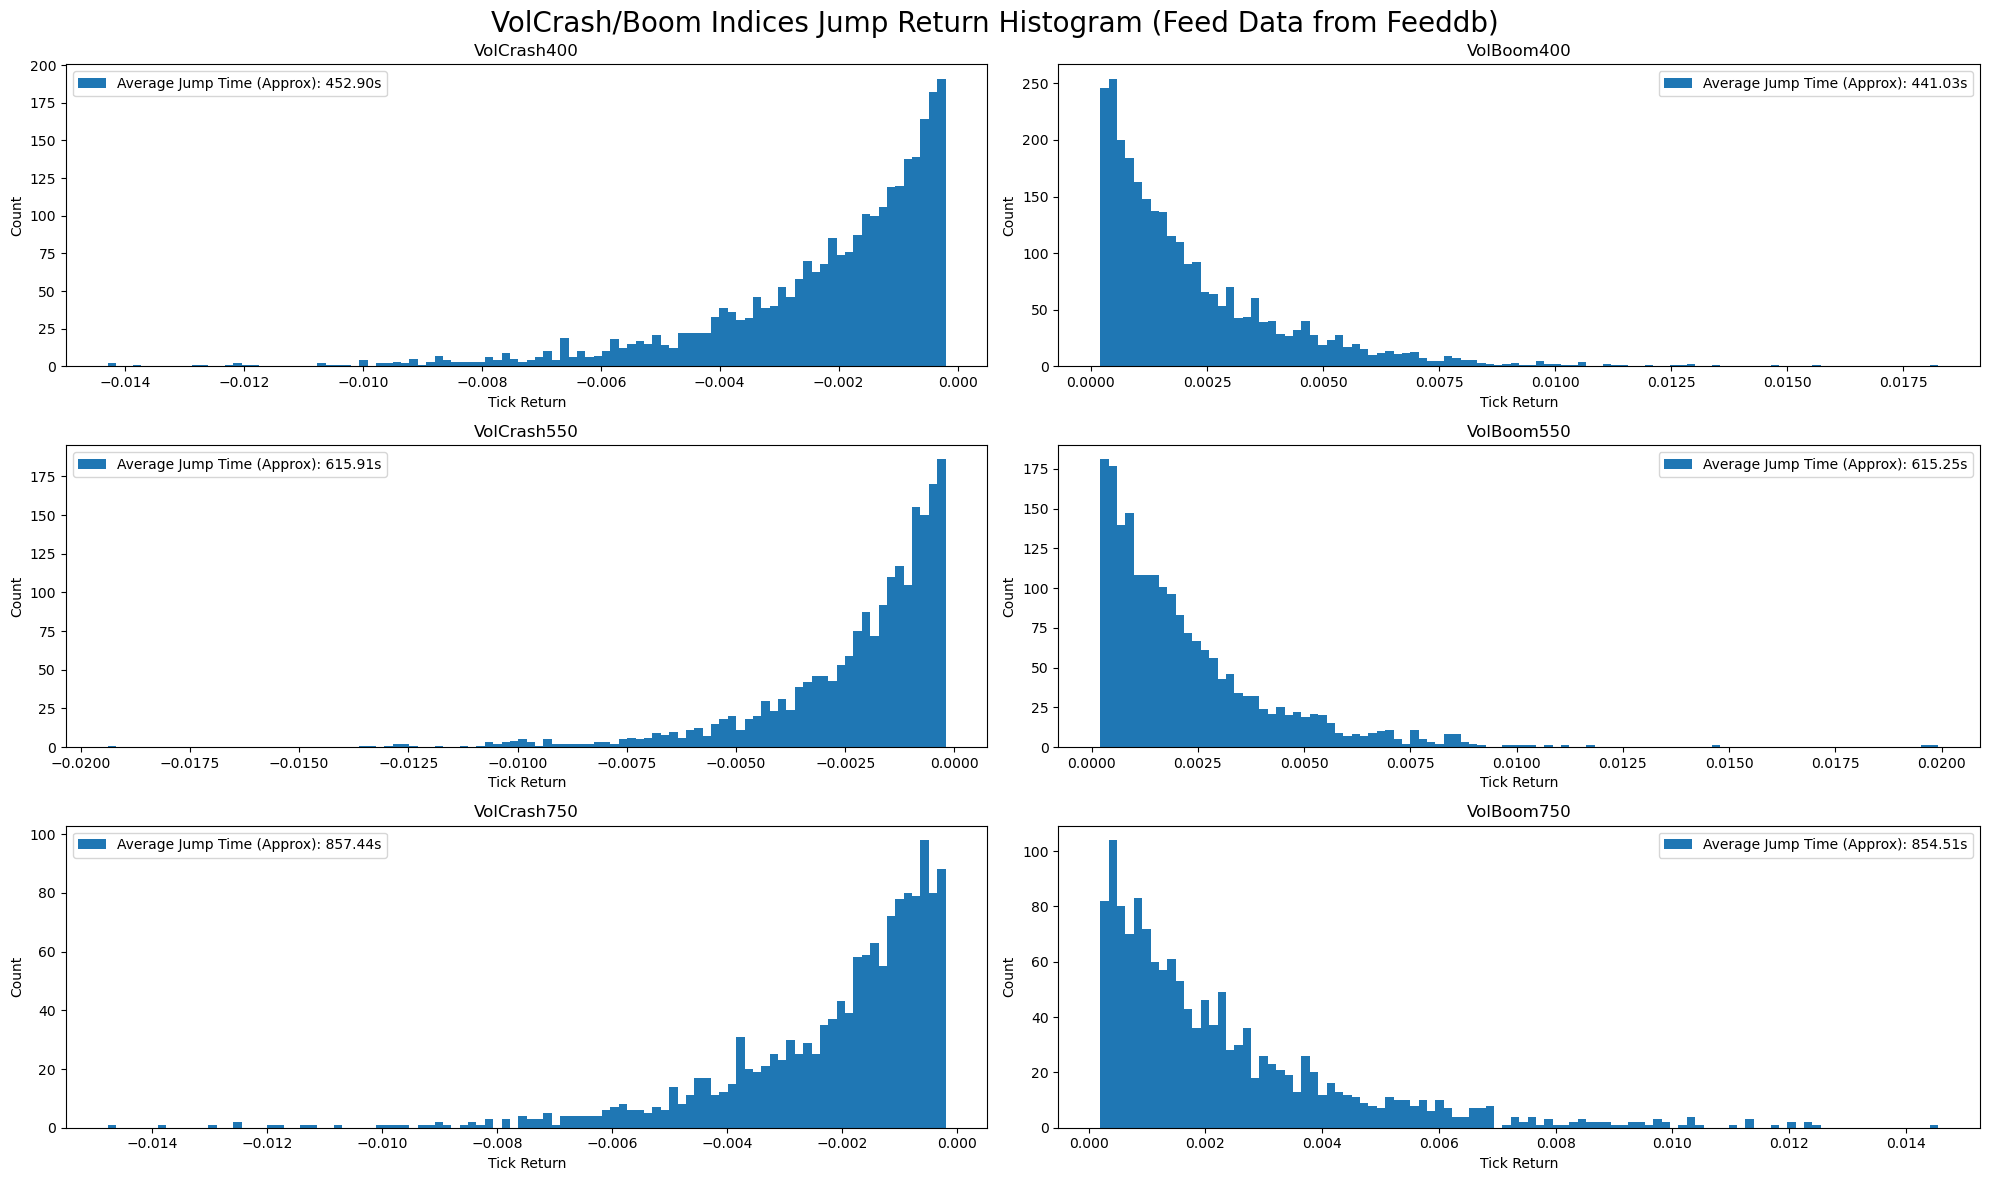

In [80]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(20,12))


for i in range(len(dex_VolCrash)):

    dex_c = dex_VolCrash[i]
    dex_b = dex_VolBoom[i]

    ax[i,0].hist(dex_c[abs(dex_c['return'])>0.0002]['return'],bins=100, label=f"Average Jump Time (Approx): {dex_c[abs(dex_c['return'])>0.0002]['return'].index.to_series().diff().mean():.2f}s");
    ax[i,1].hist(dex_b[abs(dex_b['return'])>0.0002]['return'],bins=100, label=f"Average Jump Time (Approx): {dex_b[abs(dex_b['return'])>0.0002]['return'].index.to_series().diff().mean():.2f}s");

    ax[i,0].set_xlabel('Tick Return')
    ax[i,0].set_ylabel('Count')
    ax[i,1].set_xlabel('Tick Return')
    ax[i,1].set_ylabel('Count')

    ax[i,0].set_title(dex_VolCrash_name[i])
    ax[i,1].set_title(dex_VolBoom_name[i])
    ax[i,0].legend()
    ax[i,1].legend()

plt.suptitle('VolCrash/Boom Indices Jump Return Histogram (Feed Data from Feeddb)',fontsize=20)

plt.tight_layout()

And the step distributions are normal, biased in the right direction (Opposite of jumps), with the correct volatility.

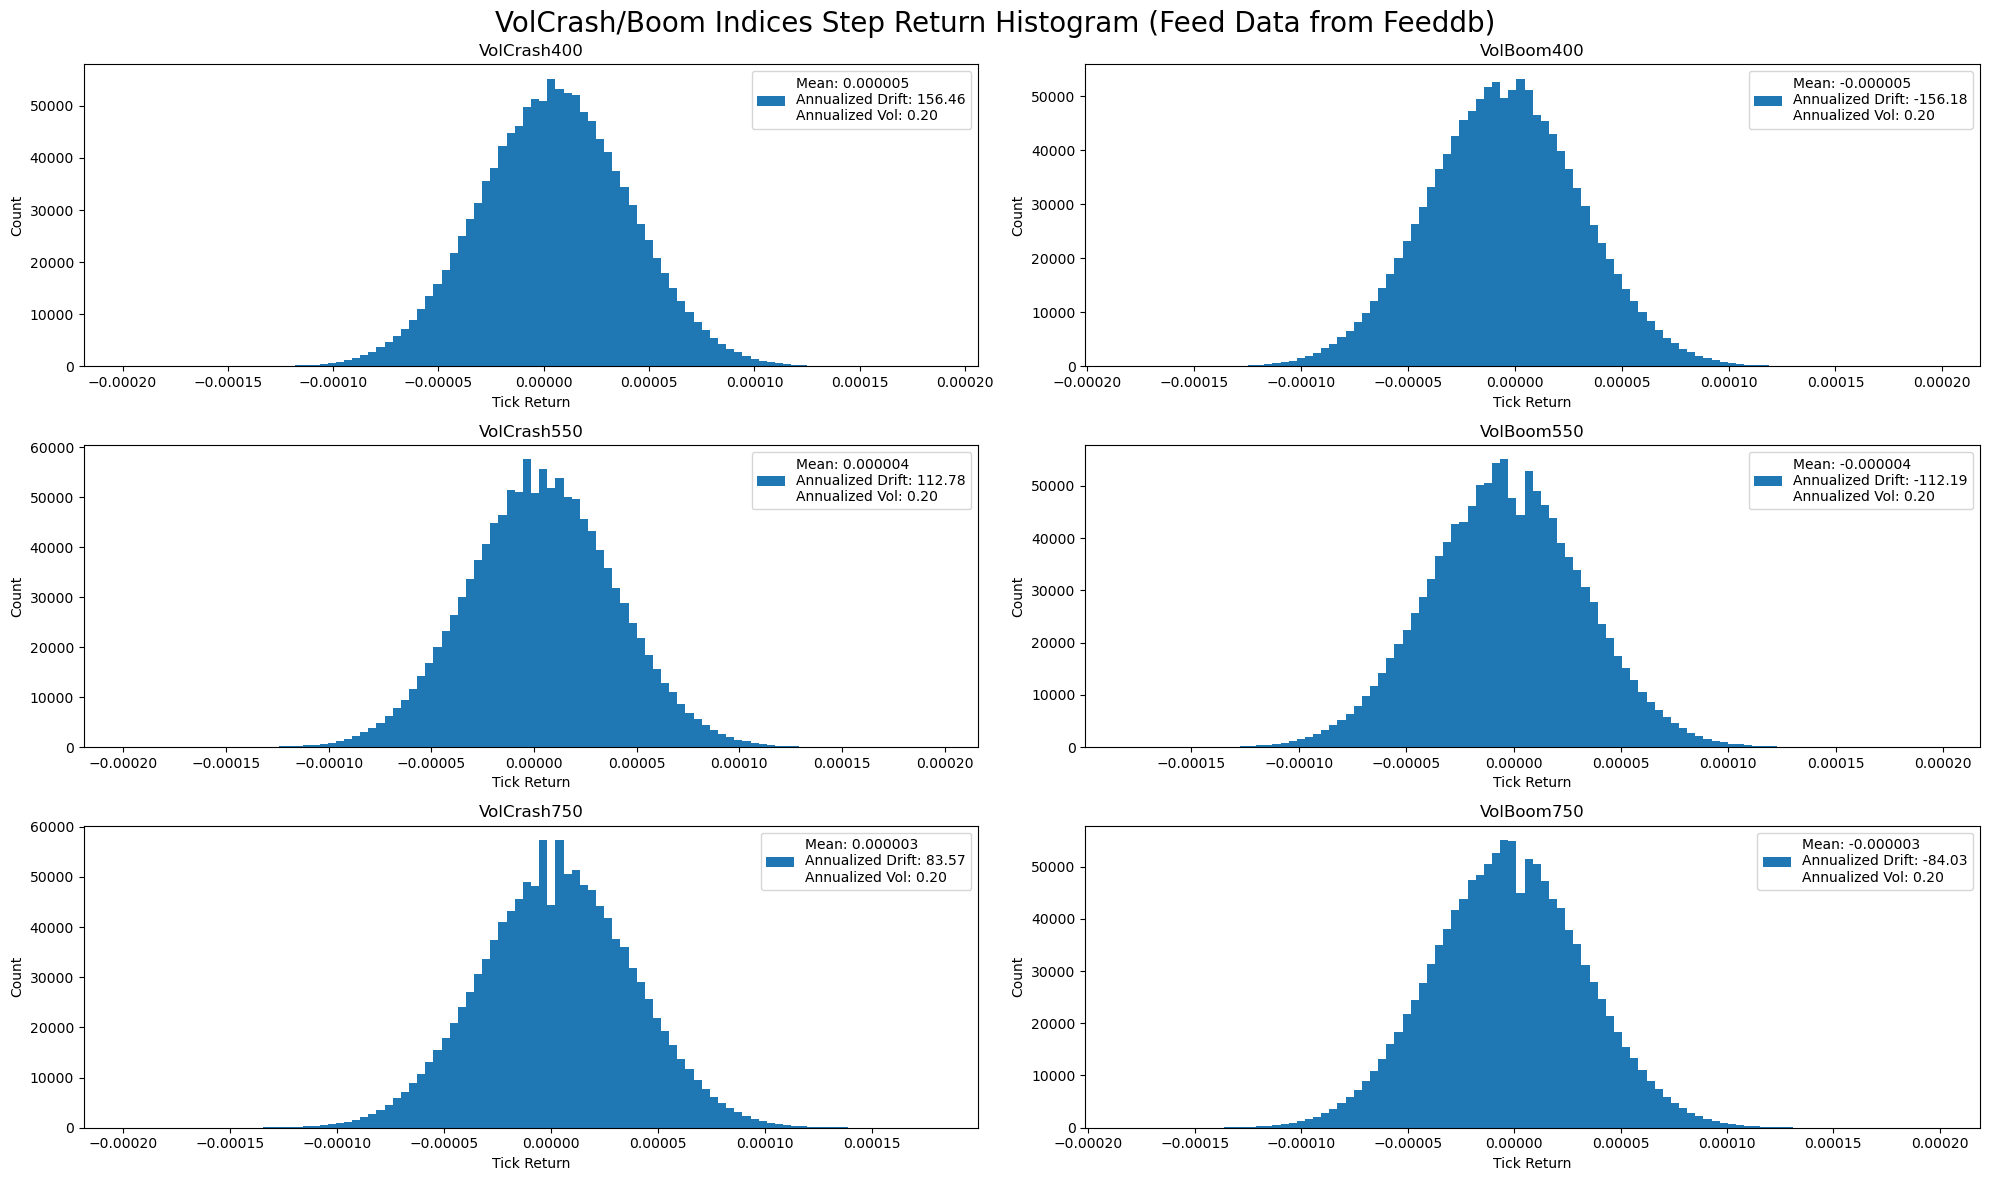

In [81]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(20,12))


for i in range(len(dex_VolCrash)):

    dex_c = dex_VolCrash[i]
    dex_b = dex_VolBoom[i]
    dex_c_label = f"Mean: {dex_c[abs(dex_c['return']) < 0.0002]['return'].mean():.6f}\nAnnualized Drift: {dex_c[abs(dex_c['return']) < 0.0002]['return'].mean() * 365 * 86400:.2f}\nAnnualized Vol: {dex_c[abs(dex_c['return']) < 0.0002]['return'].std() * np.sqrt(365 * 86400):.2f}"
    dex_b_label = f"Mean: {dex_b[abs(dex_b['return']) < 0.0002]['return'].mean():.6f}\nAnnualized Drift: {dex_b[abs(dex_b['return']) < 0.0002]['return'].mean() * 365 * 86400:.2f}\nAnnualized Vol: {dex_b[abs(dex_b['return']) < 0.0002]['return'].std() * np.sqrt(365 * 86400):.2f}"
    ax[i,0].hist(dex_c[abs(dex_c['return']) < 0.0002]['return'],bins=100, label=dex_c_label);
    ax[i,1].hist(dex_b[abs(dex_b['return']) < 0.0002]['return'],bins=100, label=dex_b_label);

    ax[i,0].set_xlabel('Tick Return')
    ax[i,0].set_ylabel('Count')
    ax[i,1].set_xlabel('Tick Return')
    ax[i,1].set_ylabel('Count')

    ax[i,0].set_title(dex_VolCrash_name[i])
    ax[i,1].set_title(dex_VolBoom_name[i])
    ax[i,0].legend()
    ax[i,1].legend()

plt.suptitle('VolCrash/Boom Indices Step Return Histogram (Feed Data from Feeddb)',fontsize=20)
plt.tight_layout()

In [82]:
SECONDS_PER_YEAR = 365 * 24 * 60 * 60

index_dict = {
    'VolCrash400' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 400,
                'q' : 0,
                'eta_p' : 0,
                'eta_n' : 0.20/100,
                },
    'VolCrash550' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 550,
                'q' : 0,
                'eta_p' : 0,
                'eta_n' : 0.20/100,
                },
    'VolCrash750' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 750,
                'q' : 0,
                'eta_p' : 0,
                'eta_n' : 0.20/100,
                },
    'VolBoom400' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 400,
                'q' : 1,
                'eta_p' : 0.20/100,
                'eta_n' : 0,
                'vol' : 0.2,
                },
    'VolBoom550' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 550,
                'q' : 1,
                'eta_p' : 0.20/100,
                'eta_n' : 0,
                },
    'VolBoom750' : {'vol' : 0.2,
                'decay' : SECONDS_PER_YEAR / 750,
                'q' : 1,
                'eta_p' : 0.20/100,
                'eta_n' : 0,
                }
}

In [83]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

@nb.njit(fastmath=True)
def mgf_jump(q,eta_p,eta_n,t=0):
    return q/(1-t*eta_p)+(1-q)/(1+t*eta_n)

@nb.njit(fastmath=True)
def inv_J_cdf_mv(cdf,q,eta_p,eta_n):
    if cdf<1-q:
        return eta_n*np.log(cdf/(1-q))
    else:
        return-eta_p*np.log((1-cdf)/(q))

@nb.njit(fastmath=True)
def DEX_log_returns(eta_p, eta_n, decay, vol, q, n=1000000):
    dt = 1/365/86400
    mu = 0
    a=mgf_jump(q,eta_p,eta_n,t=1)-1
    
    W = np.zeros(n)
    N = np.zeros(n)
    jumps = np.zeros(n)

    # print('jump drift correction (-lambda * alpha * dt):', -(decay*a)*dt, f'vol drift correction (- vol^2/2 * dt):', - vol**2 / 2 * dt)

    for i in nb.prange(n):
        W[i] = np.random.normal()
        N[i] = np.random.poisson(decay * dt)
    
    for i in range(n):
        jump = 0
        for _ in range(N[i]):
            jump += inv_J_cdf_mv(np.random.uniform(),q,eta_p,eta_n)
        jumps[i] = jump

    log_S = np.zeros(n+1)
    
    for i in nb.prange(n):
        log_S[i+1] = (mu-vol**2/2-decay*a)*dt + vol*np.sqrt(dt) * W[i] + jumps[i]

    
    return log_S 

def DEX_sim(index, n=1000000, seed=None):
    S0 = 100
    if seed is not None:
        np.random.seed(seed)
    params = index_dict[index]
    log_S = DEX_log_returns(**params, n=n)
    return S0 * np.exp(np.cumsum(log_S))

n=86400*365
S_VolCrash400=DEX_sim("VolCrash400",n=n)
S_VolCrash550=DEX_sim("VolCrash550",n=n)
S_VolCrash750=DEX_sim("VolCrash750",n=n)
S_VolBoom400=DEX_sim("VolBoom400",n=n)
S_VolBoom550=DEX_sim("VolBoom550",n=n)
S_VolBoom750=DEX_sim("VolBoom750",n=n)

r_VolCrash400 = np.log(S_VolCrash400[1:]/S_VolCrash400[:-1])
r_VolCrash550 = np.log(S_VolCrash550[1:]/S_VolCrash550[:-1])
r_VolCrash750 = np.log(S_VolCrash750[1:]/S_VolCrash750[:-1])
r_VolBoom400 = np.log(S_VolBoom400[1:]/S_VolBoom400[:-1])
r_VolBoom550 = np.log(S_VolBoom550[1:]/S_VolBoom550[:-1])
r_VolBoom750 = np.log(S_VolBoom750[1:]/S_VolBoom750[:-1])


sims = dict(zip(index_dict.keys(), [S_VolCrash400, S_VolCrash550, S_VolCrash750, S_VolBoom400, S_VolBoom550, S_VolBoom750]))
returns = dict(zip(index_dict.keys(), [r_VolCrash400, r_VolCrash550, r_VolCrash750, r_VolBoom400, r_VolBoom550, r_VolBoom750]))

In [84]:
# Calculating Moment from Empirical Data
def emp_moment(index,df,df_moment):
    df_moment.loc[index,'Mean'] = df['return'].mean()
    df_moment.loc[index,'Volatility'] = df['return'].std()*np.sqrt(365*86400)
    df_moment.loc[index,'Skewness'] = skew(df['return'])
    df_moment.loc[index,'Kurtosis'] = kurtosis(df['return'])
    return df_moment

# Calculating Moment from Simulation Data
def true_moment1(df,*rets):
    result = df.copy()
    for index, ret in zip(index_dict.keys(), rets):
        result.loc[index,'Mean'] = np.mean(ret)
        result.loc[index,'Volatility'] = np.std(ret)*np.sqrt(365*86400)
        result.loc[index,'Skewness'] = skew(ret)
        result.loc[index,'Kurtosis'] = kurtosis(ret)
    return result


def true_moment(df,index):
    params = list(index_dict[index].values())

    dt=1/365/86400
    vol = params[0]
    lam = params[1]
    q = params[2]
    eta_p = params[3]
    eta_n = params[4]
    a = mgf_jump(q,eta_p,eta_n,t=1)-1

    p=1-q

    df.loc[index,'Mean'] =  -0.5*vol**2*dt-lam*dt*a + lam*dt*(q*eta_p-p*eta_n)
    variance = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
    df.loc[index,'Volatility'] =np.sqrt(variance*365*86400)
    

    df.loc[index,'Skewness'] = lam*dt*factorial(3)*((-1)**(3)*p*eta_n**(3)+q*eta_p**(3))/(variance**(3/2))
    df.loc[index,'Kurtosis'] = lam*dt*factorial(4)*((-1)**(4)*p*eta_n**(4)+q*eta_p**(4))/(variance**(4/2))

    return df


#### Moment Matching on Demo Data only

In [85]:
demo_time = '2024-08-26 07:29:00'
df_feed = pd.DataFrame(index=index_dict.keys(),columns = ['Mean','Volatility','Skewness','Kurtosis'])

for index_name in index_dict.keys():
    dexvc = dex_VolCrashBoom_dict[index_name]
    df_feed = emp_moment(index_name, dexvc[dexvc['ts']>=demo_time],df_feed)

df_true = pd.DataFrame(index=index_dict.keys(),columns = ['Mean','Volatility','Skewness','Kurtosis'])

for index_name in dex_VolCrash_name:
    df_true = true_moment(df_true,index_name)

for index_name in dex_VolBoom_name:
    df_true = true_moment(df_true,index_name)

df_diff_abs = df_feed-df_true
df_diff_rel = df_feed/df_true -1

pd.set_option("display.precision", 9)
display_side_by_side(df_feed,df_true,df_diff_abs,df_diff_rel,titles=['Feed Data Moments (Demo Data Only)','True Moments','Difference (abs)','Difference (rel)'])

,Mean,Volatility,Skewness,Kurtosis
VolCrash400,-0.000000187,0.84337779,-40.256888378,2262.596197806
VolCrash550,-0.000000135,0.742422885,-46.674946046,3033.43002554
VolCrash750,0.000000355,0.556750364,-50.997719114,3942.82898582
VolBoom400,-0.00000028,0.803840048,43.447797721,2841.732981484
VolBoom550,0.000000055,0.681293004,38.139488686,1932.944987681
VolBoom750,-0.000000009,0.630178538,52.039863128,3828.183651538
,Mean,Volatility,Skewness,Kurtosis
VolCrash400,-0.000000011,0.818974969,-38.688266564,2122.276346075
VolCrash550,-0.000000008,0.706190806,-43.885624299,2791.859200819
VolCrash750,-0.000000006,0.613501426,-49.084362442,3594.354169577



#### Moment Matching on Dev Data only

In [86]:
demo_time = '2024-08-26 07:29:00'
df_feed = pd.DataFrame(index=index_dict.keys(),columns = ['Mean','Volatility','Skewness','Kurtosis'])

for index_name in index_dict.keys():
    dexvc = dex_VolCrashBoom_dict[index_name]
    df_feed = emp_moment(index_name, dexvc[dexvc['ts']<demo_time],df_feed)

df_true = pd.DataFrame(index=index_dict.keys(),columns = ['Mean','Volatility','Skewness','Kurtosis'])

for index_name in dex_VolCrash_name:
    df_true = true_moment(df_true,index_name)

for index_name in dex_VolBoom_name:
    df_true = true_moment(df_true,index_name)

df_diff_abs = df_feed-df_true
df_diff_rel = df_feed/df_true -1

pd.set_option("display.precision", 9)
display_side_by_side(df_feed,df_true,df_diff_abs,df_diff_rel,titles=['Feed Data Moments (Dev Data Only)','True Moments','Difference (abs)','Difference (rel)'])

,Mean,Volatility,Skewness,Kurtosis
VolCrash400,0.000000123,0.806588308,-36.816103272,1796.592217063
VolCrash550,-0.000000002,0.713066752,-46.217438899,3144.066566026
VolCrash750,0.000000012,0.611159733,-48.52777544,3486.17730592
VolBoom400,0.00000014,0.829999578,37.087205819,1862.012871363
VolBoom550,0.000000025,0.707227596,46.607430421,3453.012634576
VolBoom750,0.000000095,0.645112398,48.984240402,3335.910330168
,Mean,Volatility,Skewness,Kurtosis
VolCrash400,-0.000000011,0.818974969,-38.688266564,2122.276346075
VolCrash550,-0.000000008,0.706190806,-43.885624299,2791.859200819
VolCrash750,-0.000000006,0.613501426,-49.084362442,3594.354169577



#### Moment Matching on Combined Data

In [87]:
df_feed = pd.DataFrame(index=index_dict.keys(),columns = ['Mean','Volatility','Skewness','Kurtosis'])

for index_name in index_dict.keys():
    dexvc = dex_VolCrashBoom_dict[index_name]
    df_feed = emp_moment(index_name, dexvc, df_feed)

df_true = pd.DataFrame(index=index_dict.keys(),columns = ['Mean','Volatility','Skewness','Kurtosis'])

for index_name in dex_VolCrash_name:
    df_true = true_moment(df_true,index_name)

for index_name in dex_VolBoom_name:
    df_true = true_moment(df_true,index_name)

df_diff_abs = df_feed-df_true
df_diff_rel = df_feed/df_true -1

pd.set_option("display.precision", 9)
display_side_by_side(df_feed,df_true,df_diff_abs,df_diff_rel,titles=['Feed Data Moments (Combined)','True Moments','Difference (abs)','Difference (rel)'])

,Mean,Volatility,Skewness,Kurtosis
VolCrash400,0.000000038,0.81692275,-37.885321411,1945.898718059
VolCrash550,-0.000000039,0.721300375,-46.378612028,3113.991845828
VolCrash750,0.000000106,0.596617203,-49.200410308,3604.150657233
VolBoom400,0.000000024,0.82285232,38.737420244,2110.117898942
VolBoom550,0.000000034,0.700154793,44.469879571,3080.057395177
VolBoom750,0.000000066,0.641019107,49.794649478,3464.439821177
,Mean,Volatility,Skewness,Kurtosis
VolCrash400,-0.000000011,0.818974969,-38.688266564,2122.276346075
VolCrash550,-0.000000008,0.706190806,-43.885624299,2791.859200819
VolCrash750,-0.000000006,0.613501426,-49.084362442,3594.354169577


### Section 2

Here we check the parameters backward engineering from the feed data moments.

The result is highly dependable on the initial and boundary condition. The difference in the results are acceptable, within a 6% margin.

In [88]:
def eq_moment(params,n):
    dt=1/365/86400
    vol   = params[0]
    lam   = params[1]
    q     = params[2]
    eta_p = params[3]
    eta_n = params[4]
    a = mgf_jump(q,eta_p,eta_n,t=1)-1

    p=1-q

    if n==1:
        result = -0.5*vol**2*dt-lam*dt*a + lam*dt*(q*eta_p-p*eta_n)
    elif n==2:
        result = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
    else:
        variance = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
        result = lam*dt*factorial(n)*((-1)**(n)*p*eta_n**(n)+q*eta_p**(n))/(variance**(n/2))
    return result

def func(params,moments):
    eq =[eq_moment(params,1) - moments[0], eq_moment(params,2) - moments[1], eq_moment(params,3) - moments[2], eq_moment(params,4) - moments[3], eq_moment(params,5) - moments[4]]
    result = np.sum(np.power(eq,2))
    return result

def params_solve(index,df):
    # Get the target
    moment_1 = np.mean(df['return']**1)
    moment_2 = np.mean((df['return']-moment_1)**2)
    moment_3 = np.mean((df['return']-moment_1)**3)/moment_2**(3/2)
    moment_4 = np.mean((df['return']-moment_1)**4)/moment_2**(4/2)
    moment_5 = np.mean((df['return']-moment_1)**5)/moment_2**(5/2)
    moment_6 = np.mean((df['return']-moment_1)**6)/moment_2**(6/2)

    moments = [moment_1,moment_2,moment_3,moment_4,moment_5,moment_6]

    # Solve for the unknown parameters
    params_guess = list(index_dict[index].values())
    params_guess = np.multiply(params_guess,0.97)

    bound = 0.025
    bounds = []
    for params in params_guess:
        bounds.append((params*(1-bound),params*(1+bound)))

    result = minimize(func,params_guess,bounds=bounds,args=(moments))
    params_solve = result.x
    return params_solve


df_params_feed = pd.DataFrame(index=index_dict.keys(),columns = ['Vol','Lambda','Probability','Positive Eta','Negative Eta'])


for i, df in enumerate(dex_VolCrash):
    index_name = dex_VolCrash_name[i]
    dex_params = params_solve(index_name,df)
    df_params_feed.loc[index_name,'Vol'] = dex_params[0]
    df_params_feed.loc[index_name,'Lambda'] = dex_params[1]
    df_params_feed.loc[index_name,'Probability'] = dex_params[2]
    df_params_feed.loc[index_name,'Positive Eta'] = dex_params[3]
    df_params_feed.loc[index_name,'Negative Eta'] = dex_params[4]

for i, df in enumerate(dex_VolBoom):
    index_name = dex_VolBoom_name[i]
    dex_params = params_solve(index_name,df)
    df_params_feed.loc[index_name,'Vol'] = dex_params[0]
    df_params_feed.loc[index_name,'Lambda'] = dex_params[1]
    df_params_feed.loc[index_name,'Probability'] = dex_params[2]
    df_params_feed.loc[index_name,'Positive Eta'] = dex_params[3]
    df_params_feed.loc[index_name,'Negative Eta'] = dex_params[4]

df_params_true = pd.DataFrame(index=index_dict.keys(), columns = ['Vol','Lambda','Probability','Positive Eta','Negative Eta'])

for index_name, params in {k : list(v.values()) for k, v in index_dict.items()}.items():
    df_params_true.loc[index_name,'Vol'] = params[0]
    df_params_true.loc[index_name,'Lambda'] = params[1]
    df_params_true.loc[index_name,'Probability'] = params[2]
    df_params_true.loc[index_name,'Positive Eta'] = params[3]
    df_params_true.loc[index_name,'Negative Eta'] = params[4]

df_params_diff = df_params_feed/df_params_true-1

pd.set_option("display.precision", 8)
display_side_by_side(df_params_feed,df_params_true,df_params_diff,titles=['Feed Data Params','True Params','Difference (rel)'])

,Vol,Lambda,Probability,Positive Eta,Negative Eta
VolCrash400,0.19885,78386.67,0.0,0.0,0.0018915
VolCrash550,0.18915,54227.58545455,0.0,0.0,0.0019885
VolCrash750,0.19885,41806.224,0.0,0.0,0.0018915
VolBoom400,0.19885,78386.67,0.99425,0.0018915,0.0
VolBoom550,0.18915,54227.58545455,0.94575,0.0019885,0.0
VolBoom750,0.19885,41806.224,0.99425,0.0018915,0.0
,Vol,Lambda,Probability,Positive Eta,Negative Eta
VolCrash400,0.2,78840.0,0,0,0.002
VolCrash550,0.2,57338.18181818,0,0,0.002
VolCrash750,0.2,42048.0,0,0,0.002


### Section 3

We want to check the convergence speed of the feed data in term of the moments.

Overall looks fine, even with only 9 days of data.

In [89]:
def eq_moment1(index,n):
    
    params = list(index_dict[index].values())

    dt=1/365/86400
    vol = params[0]
    lam = params[1]
    q = params[2]
    eta_p = params[3]
    eta_n = params[4]
    a = mgf_jump(q,eta_p,eta_n,t=1)-1

    p=1-q

    if n==1:
        result = -0.5*vol**2*dt-lam*dt*a + lam*dt*(q*eta_p-p*eta_n)
    elif n==2:
        result =np.sqrt( (vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2))*(1/dt))
    else:
        variance = vol**2*dt + 2*(lam*dt)*(q*eta_p**2+p*eta_n**2)
        result = lam*dt*factorial(n)*((-1)**(n)*p*eta_n**(n)+q*eta_p**(n))/(variance**(n/2))

    return result

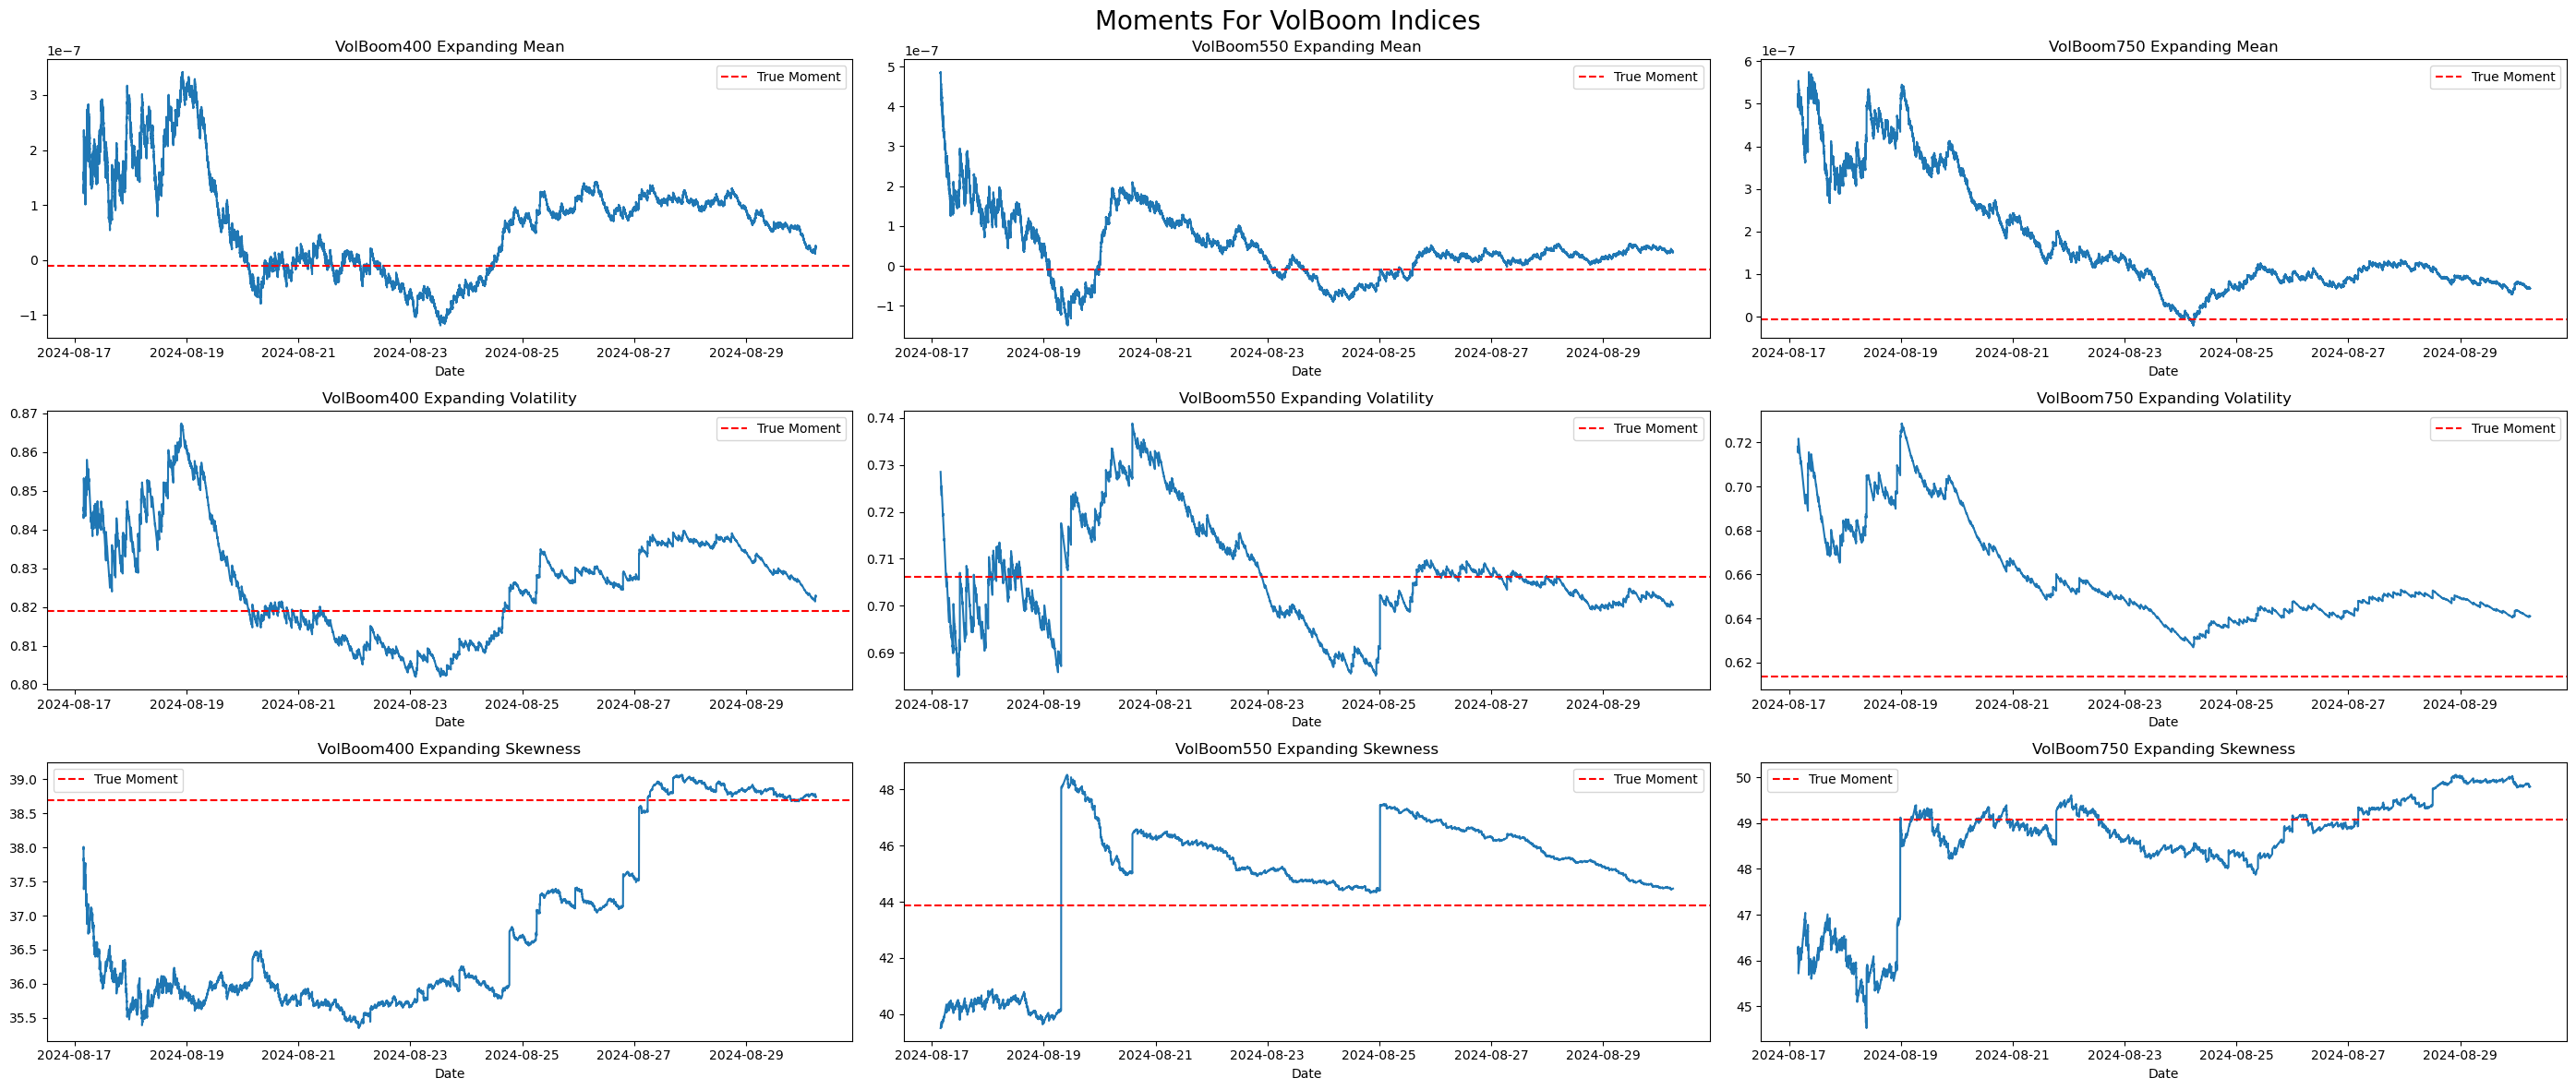

In [90]:
gap = 100_000

for volb in dex_VolBoom:
    volb['expanding_mean'] = volb['return'].expanding(gap).mean()
    volb['expanding_vol'] = volb['return'].expanding(gap).std()* np.sqrt(365*86400)
    volb['expanding_skew'] = volb['return'].expanding(gap).skew()

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(28,12))

for i, dexb_name in enumerate(dex_VolBoom_name):
    df= dex_VolBoom[i]

    ax[0,i].plot(df['ts'],df['expanding_mean'])
    ax[1,i].plot(df['ts'],df['expanding_vol'])
    ax[2,i].plot(df['ts'],df['expanding_skew'])


    ax[0,i].set_title(f'{dexb_name} Expanding Mean')
    ax[1,i].set_title(f'{dexb_name} Expanding Volatility')
    ax[2,i].set_title(f'{dexb_name} Expanding Skewness')

    moment = eq_moment1(dexb_name,1)
    ax[0,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    moment = eq_moment1(dexb_name,2)
    ax[1,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    moment = eq_moment1(dexb_name,3)
    ax[2,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    for j in range(3):
        ax[j,i].set_xlabel('Date')
        ax[j,i].legend()

plt.suptitle("Moments For VolBoom Indices", fontsize=20)
plt.tight_layout()


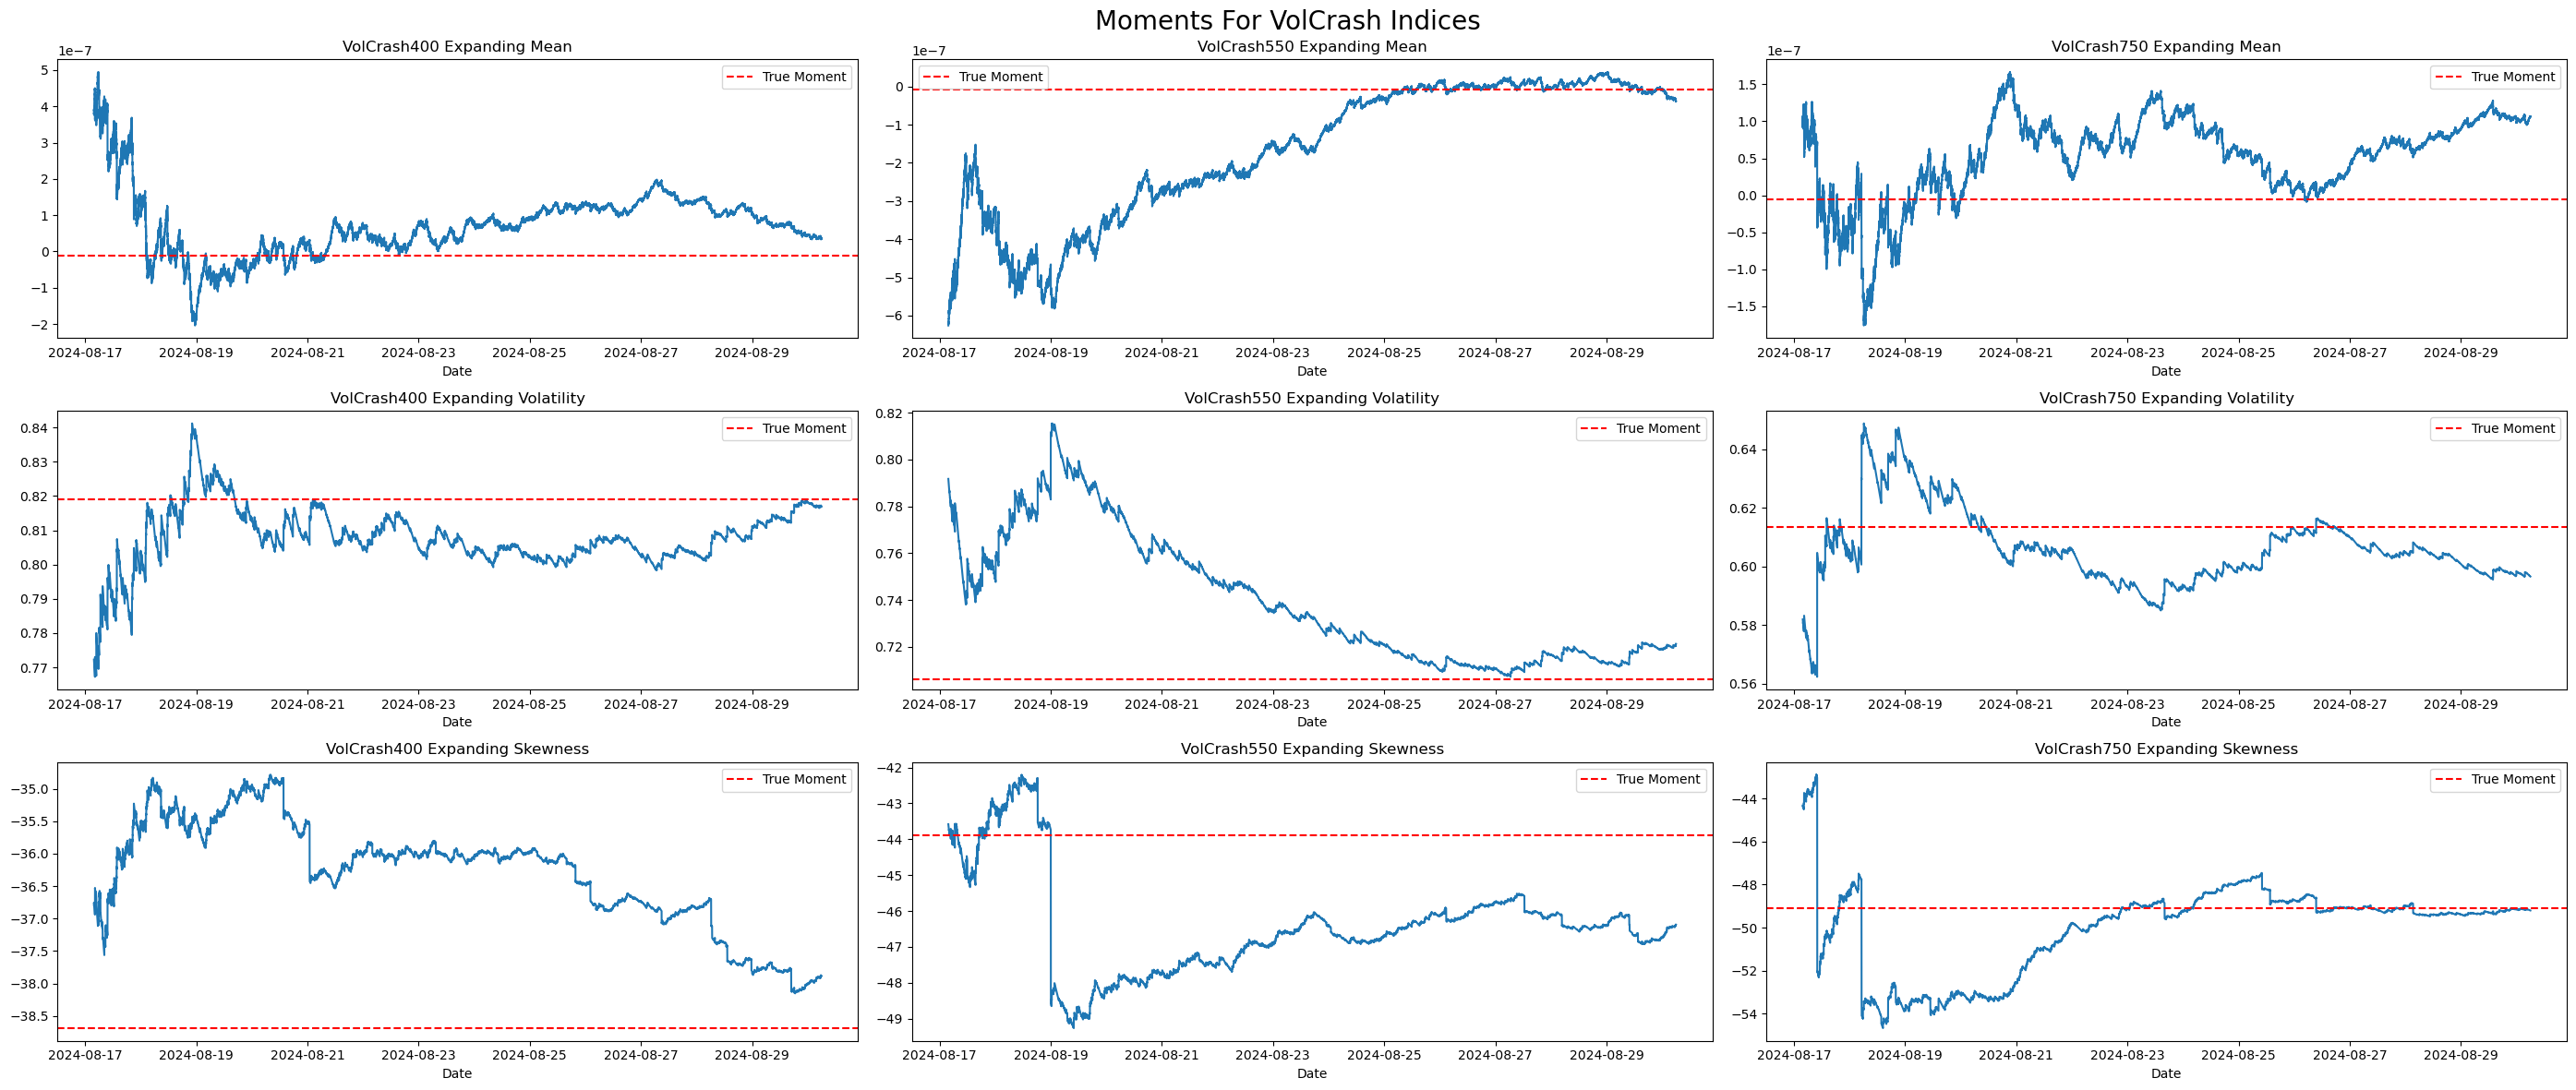

In [91]:
gap = 100_000

for volc in dex_VolCrash:
    volc['expanding_mean'] = volc['return'].expanding(gap).mean()
    volc['expanding_vol'] = volc['return'].expanding(gap).std()* np.sqrt(365*86400)
    volc['expanding_skew'] = volc['return'].expanding(gap).skew()

fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(28,12))

for i, dexc_name in enumerate(dex_VolCrash_name):
    df= dex_VolCrash[i]

    ax[0,i].plot(df['ts'],df['expanding_mean'])
    ax[1,i].plot(df['ts'],df['expanding_vol'])
    ax[2,i].plot(df['ts'],df['expanding_skew'])


    ax[0,i].set_title(f'{dexc_name} Expanding Mean')
    ax[1,i].set_title(f'{dexc_name} Expanding Volatility')
    ax[2,i].set_title(f'{dexc_name} Expanding Skewness')

    moment = eq_moment1(dexc_name,1)
    ax[0,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    moment = eq_moment1(dexc_name,2)
    ax[1,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    moment = eq_moment1(dexc_name,3)
    ax[2,i].axhline(moment,color='red',label='True Moment',linestyle='dashed')

    for j in range(3):
        ax[j,i].set_xlabel('Date')
        ax[j,i].legend()

plt.suptitle("Moments For VolCrash Indices", fontsize=20)
plt.tight_layout()


### Section 4

The simulation steps of the strategy testing are:
1. Run 3-months simulation for Vol Crash 400/550/750. Vol Boom indices are not run because results are equivalent.
2. Run the trading strategy on the simulation data.
   1. Define the jump size same as the negative eta.
   2. After each jump, wait for mean jump frequency (which is 400/550/750 seconds respectively). If there is no jump, enter into a short position.
   3. Enter into additional short position every mean jump frequency if there is no jump.
   4. Exit all positions in next jump.
3. Repeat the strategy for a sufficient number of times. In here, it is 10K.
4. Plot the average PnL%, Hit Ratio and Win Rate.

In total there are 3 variations of this strategies are run too, which is to:
1. Waiting time and additional position frequency same as mean jump frequency.
2. Waiting time same as mean jump frequency but additional position frequency at 5 mins.
3. Double the waiting time and enter into additional positions every 5 mins.

Key points to conclude the strategy testing:
1. Mean Hit Ratio of 50% shows that the exploitation is not possible.
2. Mean Win Rate of 75% is expected due to the clear pattern of the index. They are higher than the DEX indices as VolC/B indices are more predictable, i.e we know the direction of the jumps always
3. Spread of 0.01% as proposed by Product Quants is sufficient for all the indices as it very comfortably covers the mean and median of the strategy PnL in %, which tend to be in the range of 0.0001%.

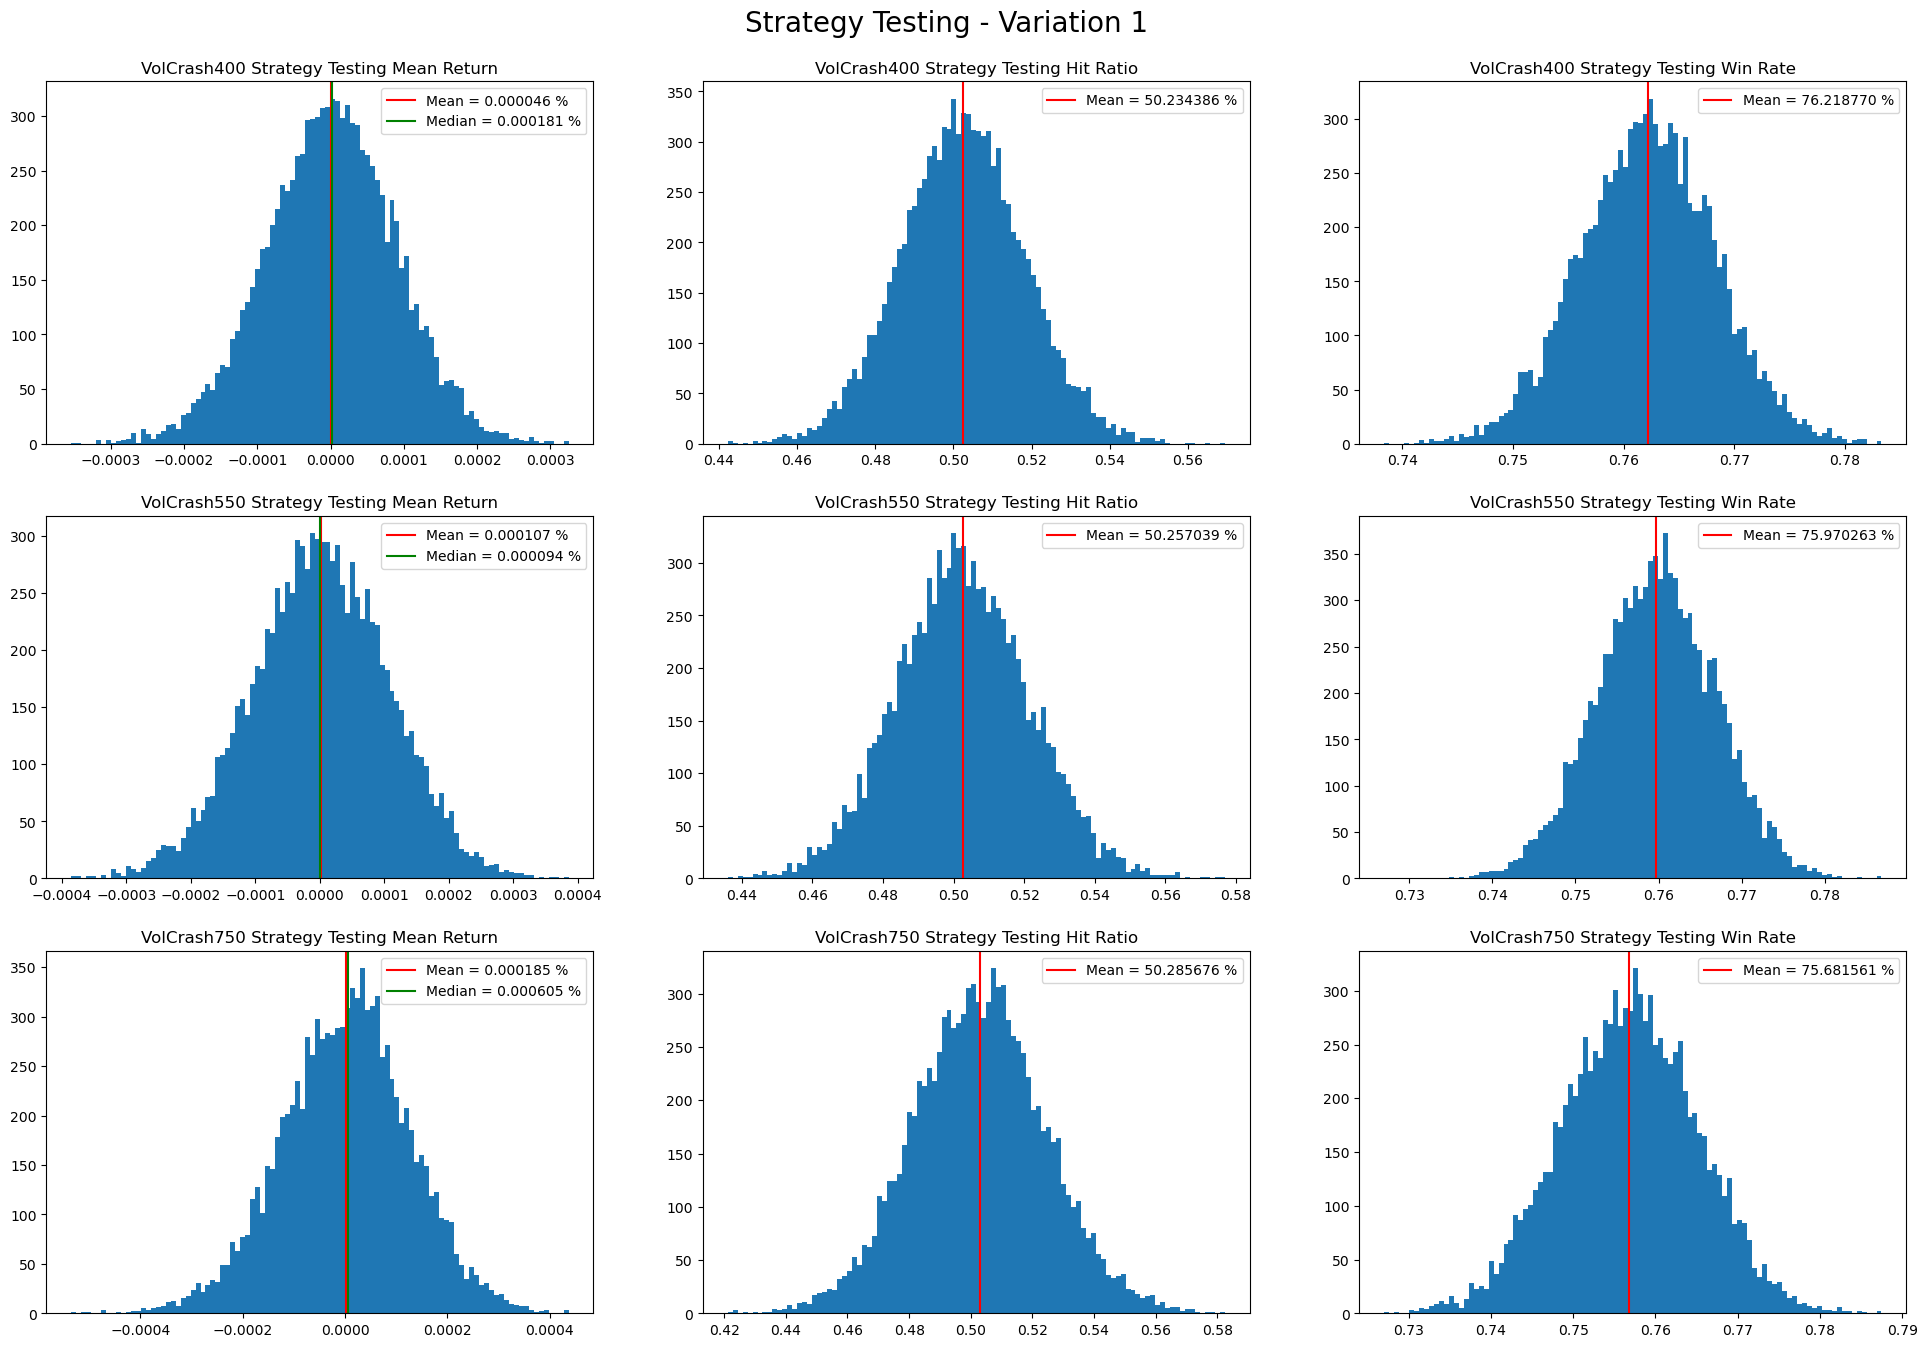

In [107]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,16))
i=0

strategy_result = pd.read_csv("strategy_results_VolCrash_Variation1.csv")
for index_name in dex_VolCrash_name:
    # Mean Return
    df_plot = strategy_result[strategy_result['index']==index_name]['Mean Return']
    ax[i,0].hist(df_plot,bins=100)
    ax[i,0].set_title(f"{index_name} Strategy Testing Mean Return")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,0].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,0].axvline(median_return,color='green',label = f"Median = {median_return*100:.6f} %")
    ax[i,0].legend()

    # Hit Ratio
    df_plot = strategy_result[strategy_result['index']==index_name]['Hit Ratio']
    ax[i,1].hist(df_plot,bins=100)
    ax[i,1].set_title(f"{index_name} Strategy Testing Hit Ratio")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,1].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,1].legend()

    # Win Rate 
    df_plot = strategy_result[strategy_result['index']==index_name]['Win Rate']
    ax[i,2].hist(df_plot,bins=100)
    ax[i,2].set_title(f"{index_name} Strategy Testing Win Rate")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,2].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,2].legend()
    
    i+=1

plt.suptitle("Strategy Testing - Variation 1",fontsize=20, y= 0.925);
# plt.tight_layout();



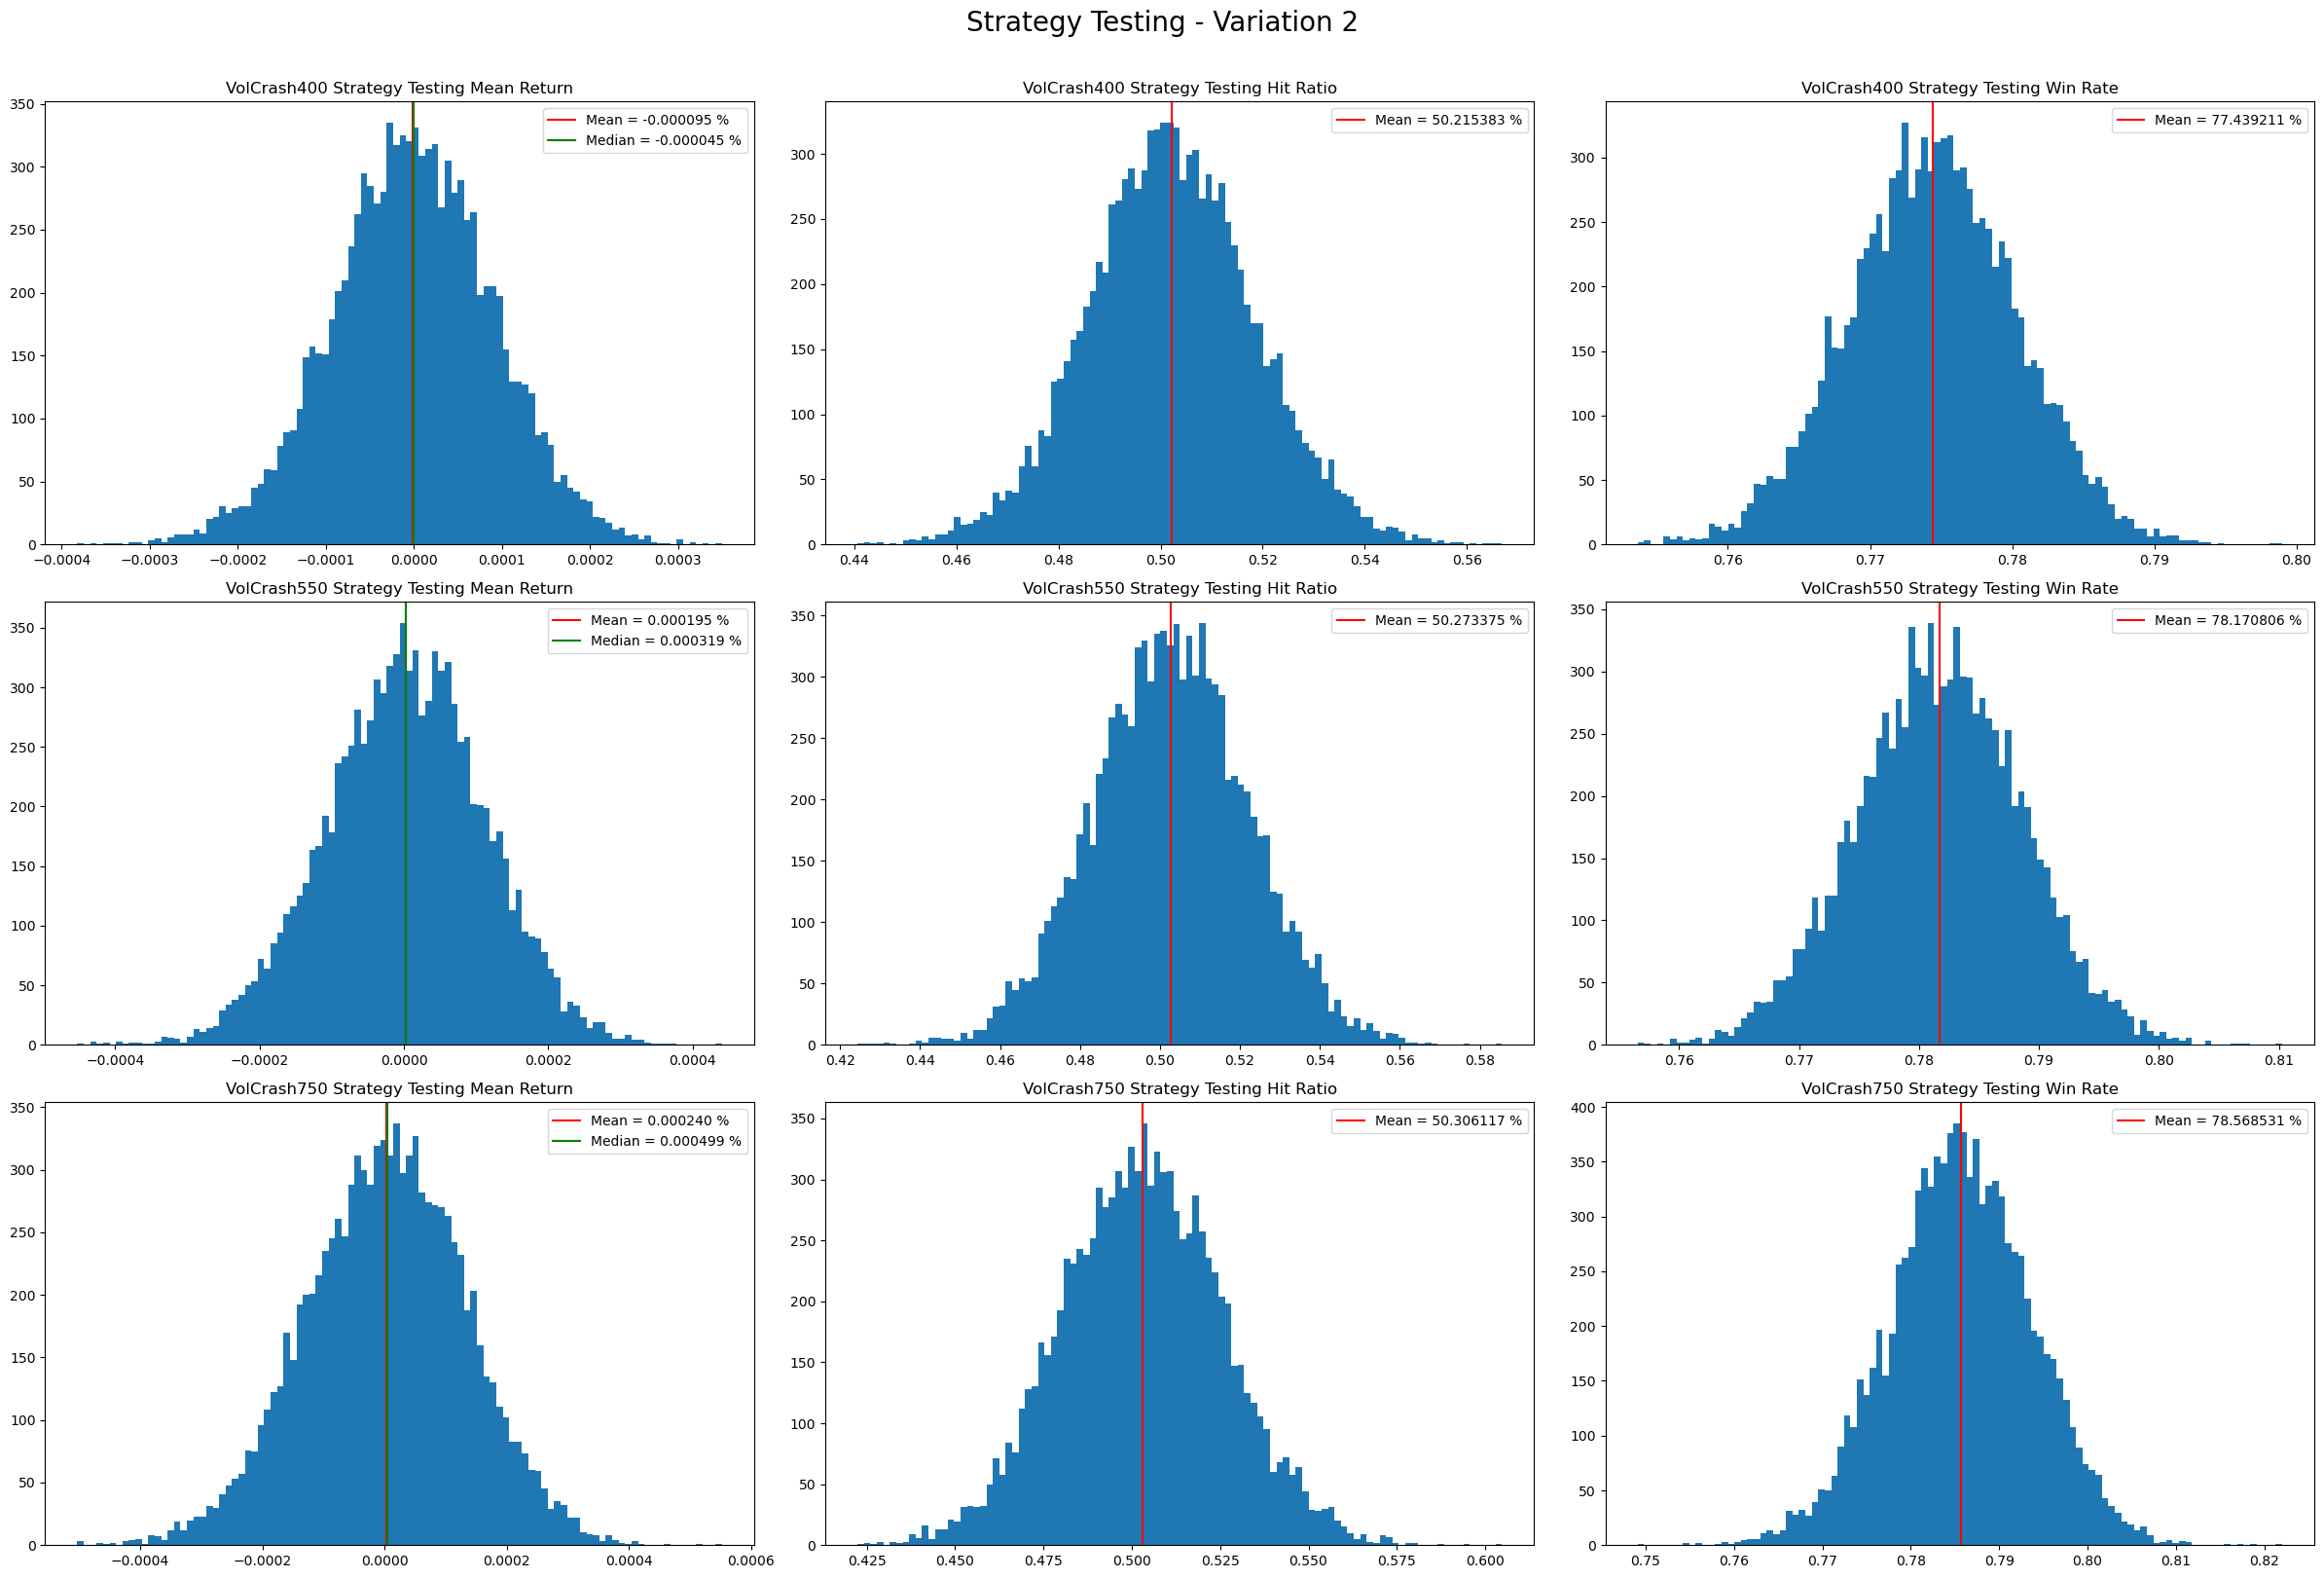

In [114]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,16))
i=0

strategy_result = pd.read_csv("strategy_results_VolCrash_Variation2.csv")
for index_name in dex_VolCrash_name:

    # Mean Return
    df_plot = strategy_result[strategy_result['index']==index_name]['Mean Return']
    ax[i,0].hist(df_plot,bins=100)
    ax[i,0].set_title(f"{index_name} Strategy Testing Mean Return")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,0].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,0].axvline(median_return,color='green',label = f"Median = {median_return*100:.6f} %")
    ax[i,0].legend()

    # Hit Ratio
    df_plot = strategy_result[strategy_result['index']==index_name]['Hit Ratio']
    ax[i,1].hist(df_plot,bins=100)
    ax[i,1].set_title(f"{index_name} Strategy Testing Hit Ratio")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,1].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,1].legend()

    # Win Rate 
    df_plot = strategy_result[strategy_result['index']==index_name]['Win Rate']
    ax[i,2].hist(df_plot,bins=100)
    ax[i,2].set_title(f"{index_name} Strategy Testing Win Rate")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,2].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,2].legend()
    
    i+=1

plt.suptitle("Strategy Testing - Variation 2",fontsize=20, y= 1.01);
plt.tight_layout();


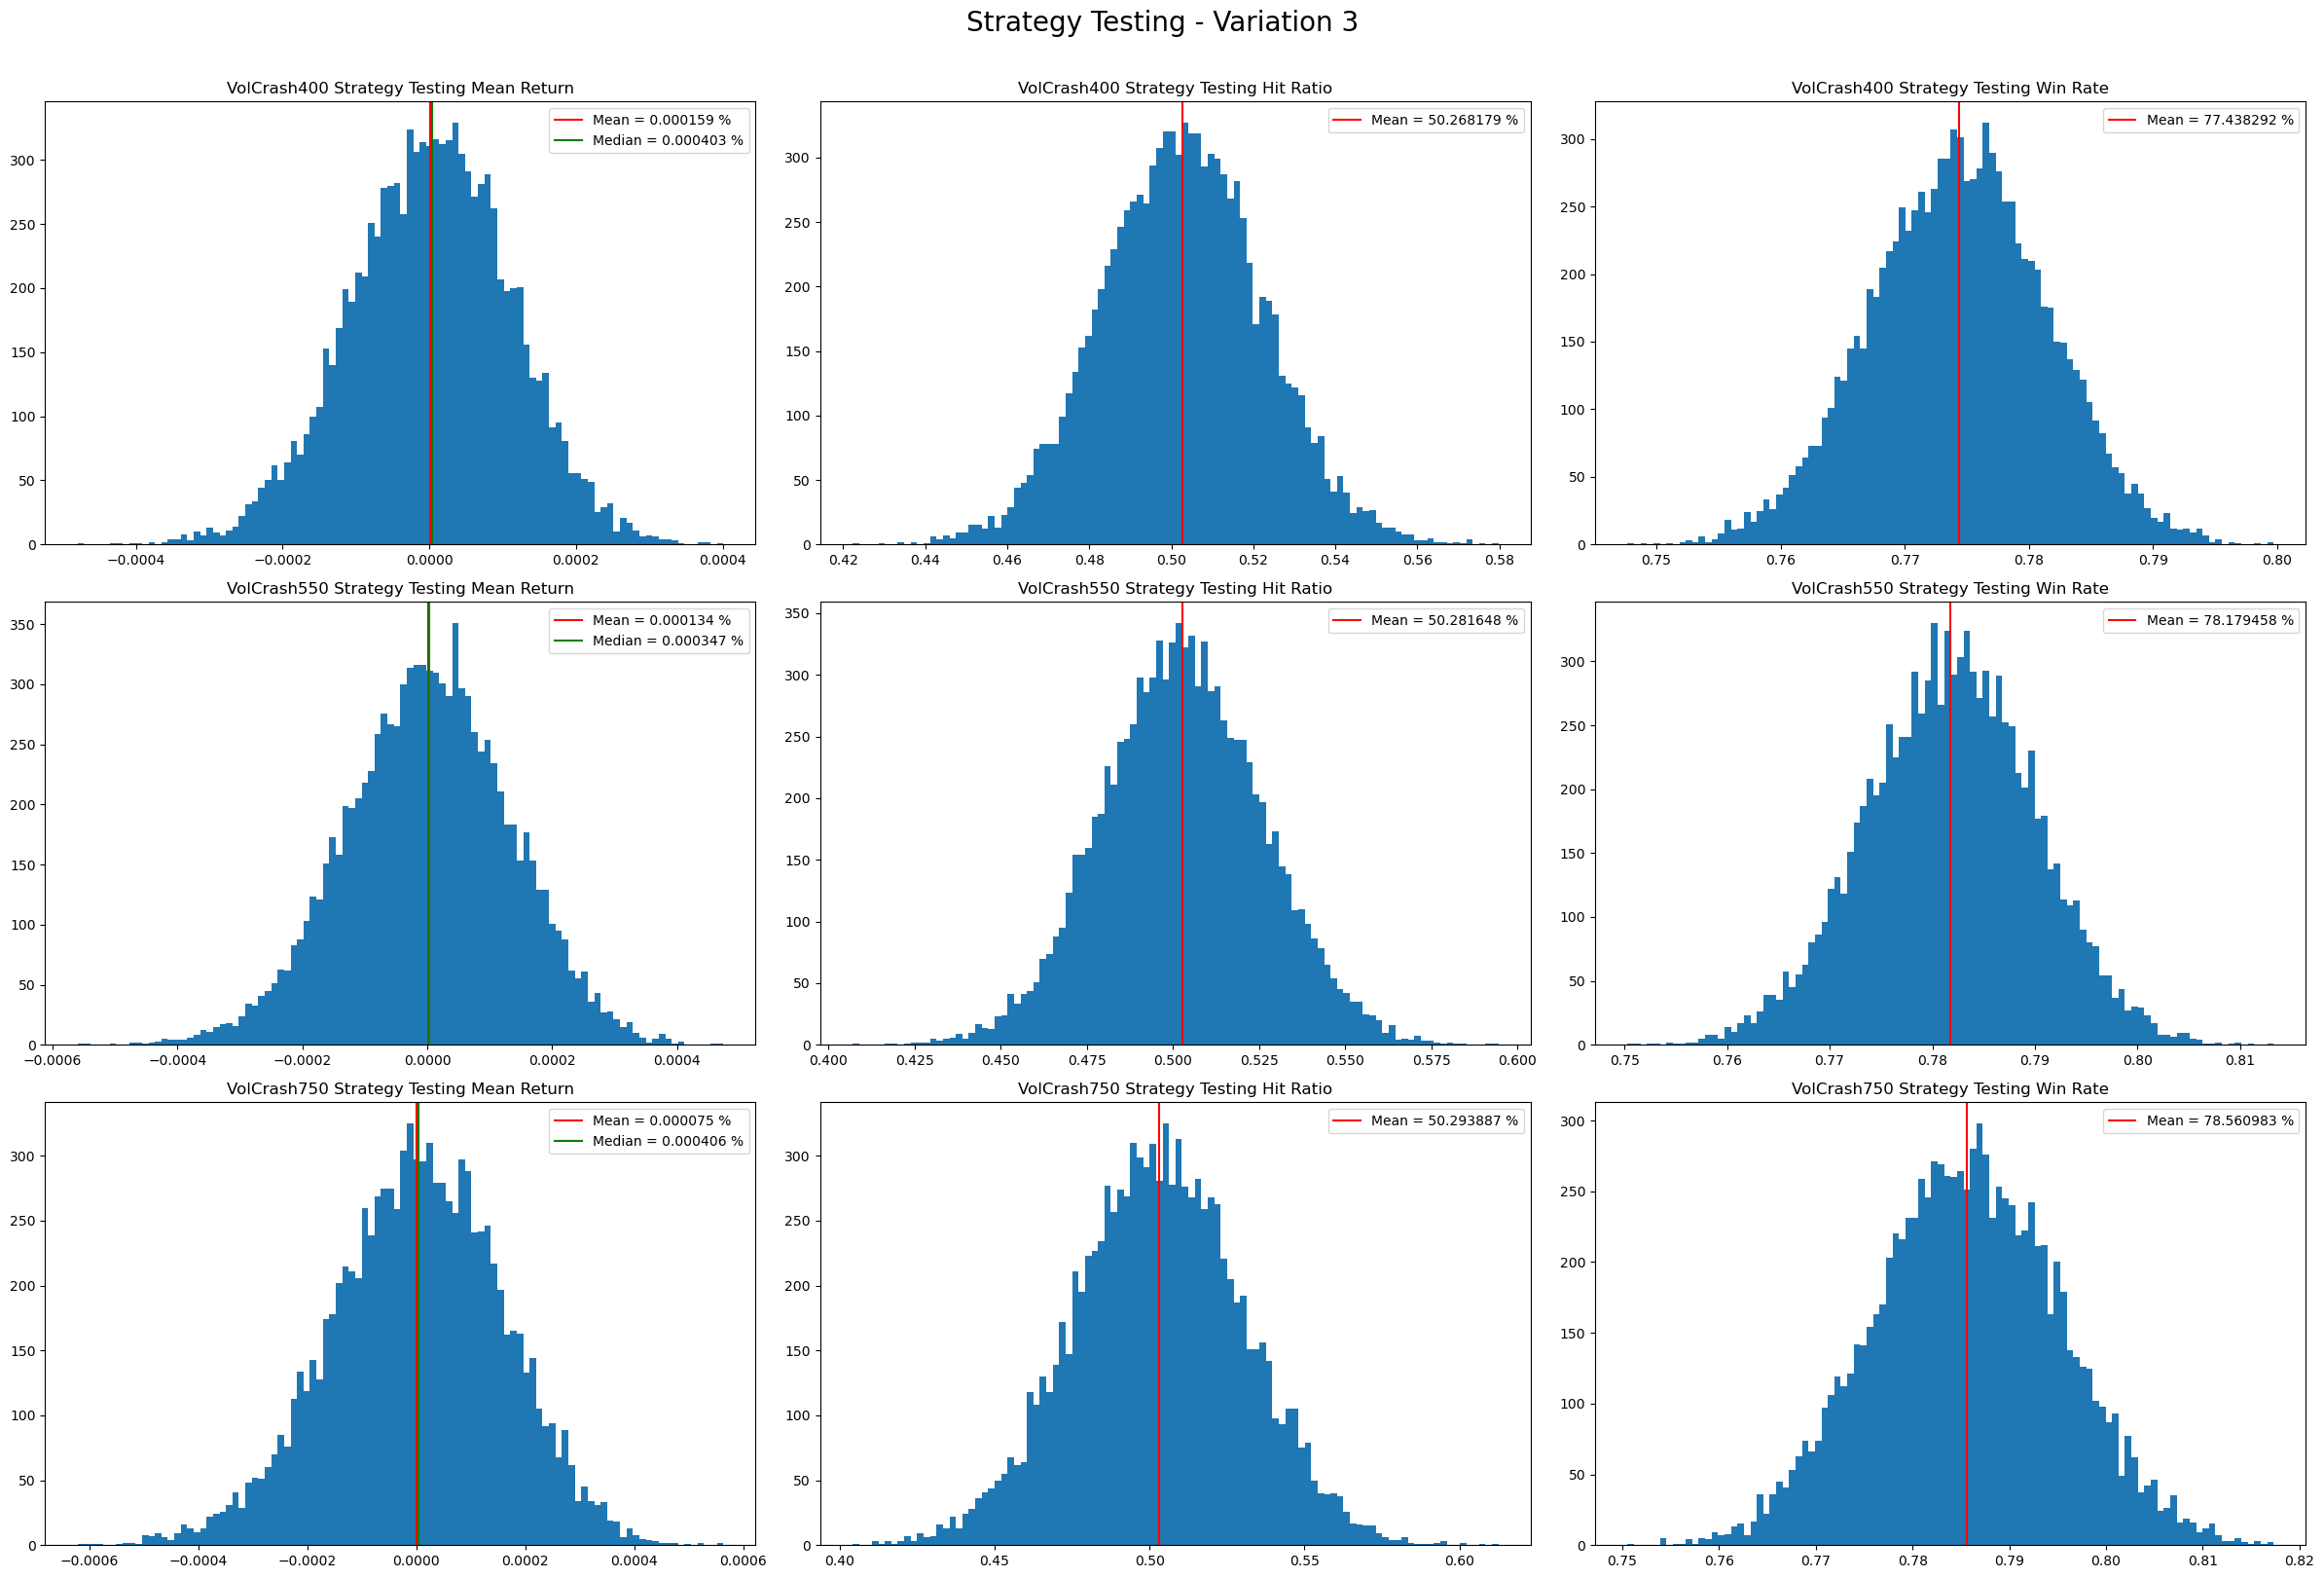

In [113]:
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(24,16))
i=0

strategy_result = pd.read_csv("strategy_results_VolCrash_Variation3.csv")
for index_name in dex_VolCrash_name:

    # Mean Return
    df_plot = strategy_result[strategy_result['index']==index_name]['Mean Return']
    ax[i,0].hist(df_plot,bins=100)
    ax[i,0].set_title(f"{index_name} Strategy Testing Mean Return")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,0].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,0].axvline(median_return,color='green',label = f"Median = {median_return*100:.6f} %")
    ax[i,0].legend()

    # Hit Ratio
    df_plot = strategy_result[strategy_result['index']==index_name]['Hit Ratio']
    ax[i,1].hist(df_plot,bins=100)
    ax[i,1].set_title(f"{index_name} Strategy Testing Hit Ratio")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,1].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,1].legend()

    # Win Rate 
    df_plot = strategy_result[strategy_result['index']==index_name]['Win Rate']
    ax[i,2].hist(df_plot,bins=100)
    ax[i,2].set_title(f"{index_name} Strategy Testing Win Rate")
    mean_return = df_plot.mean()
    median_return = df_plot.median()
    ax[i,2].axvline(mean_return,color='red',label = f"Mean = {mean_return*100:.6f} %")
    ax[i,2].legend()
    
    i+=1

plt.suptitle("Strategy Testing - Variation 3",fontsize=20, y=1.01);
plt.tight_layout();


In [95]:
# Simulation Code is here:

# variation1 = {
#     'VolCrash400' : {'t_exclude' : 400,
#                 'interval' : 400,
#                 'jump_size' : -0.20/100,
#                 },
#     'VolCrash550' : {'t_exclude' : 550,
#                 'interval' : 550,
#                 'jump_size' : -0.20/100,
#                 },
#     'VolCrash750' : {'t_exclude' : 750,
#                 'interval' : 750,
#                 'jump_size' : -0.20/100,
#                 },
# }

# variation2 = {
#     'VolCrash400' : {'t_exclude' : 400,
#                 'interval' : 5 * 60,
#                 'jump_size' : -0.20/100,
#                 },
#     'VolCrash550' : {'t_exclude' : 550,
#                 'interval' : 5 * 60,
#                 'jump_size' : -0.20/100,
#                 },
#     'VolCrash750' : {'t_exclude' : 750,
#                 'interval' : 5 * 60,
#                 'jump_size' : -0.20/100,
#                 },
# }

# variation3 = {
#     'VolCrash400' : {'t_exclude' : 2 * 400,
#                 'interval' : 5 * 60,
#                 'jump_size' : -0.20/100,
#                 },
#     'VolCrash550' : {'t_exclude' : 2 * 550,
#                 'interval' : 5 * 60,
#                 'jump_size' : -0.20/100,
#                 },
#     'VolCrash750' : {'t_exclude' : 2 * 750,
#                 'interval' : 5 * 60,
#                 'jump_size' : -0.20/100,
#                 },
# }

# n = 86400*30*3
# n_sim = 10_000

# test_params = variation1
# np.random.seed(0)
# sim_result = []
# for index in VolCrash_indices:
#     print(index)

#     t_exclude = test_params[index]['t_exclude']
#     interval = test_params[index]['interval']
#     jump_size = test_params[index]['jump_size']
    
#     for _ in range(n_sim):
#         S_mv=DEX_sim(index,n=n)
#         rets = np.diff(S_mv, prepend=np.nan) / S_mv
#         jumps = np.argwhere(rets < jump_size).flatten()
#         result = []
        
#         for i in range(len(jumps) - 2):
#             if (jumps[i+1]-jumps[i]) < t_exclude:
#                 continue
            
#             else:
#                 j = 1
#                 entry_time = jumps[i]+t_exclude
#                 while entry_time < jumps[i+1]:
#                     entry_price = S_mv[entry_time]
#                     avg_price = np.mean(S_mv[jumps[i]+t_exclude:jumps[i+1]])
#                     exit_price = S_mv[jumps[i+1]]
#                     result.append([entry_time,jumps[i+1],entry_price,avg_price,exit_price,entry_price-exit_price])
#                     entry_time += interval

#         tep = pd.DataFrame(result)
#         tep.columns = ['entry','exit','ent_spot','avg_spot','ext_spot','pl']
#         tep['hold_time'] = (tep.exit - tep.entry)
#         tep['return'] =tep.pl/tep.ent_spot

#         gb_exit = tep.groupby("exit").agg({'pl':'sum'})
#         win_rate = len(gb_exit[gb_exit.pl>0])/len(gb_exit)
#         hit_ratio = np.sum(np.where(gb_exit.pl>0,gb_exit.pl,0))/np.sum(np.where(gb_exit.pl>0,gb_exit.pl,-gb_exit.pl))

#         sim_result.append([index,i,tep.pl.sum(),len(tep),hit_ratio,win_rate,tep.pl.mean(),tep.pl.median(),tep['return'].mean(),tep['return'].median()])

# strategy_result = pd.DataFrame(sim_result)
# strategy_result.columns = ['index','sim','Total PL','Total Trades','Hit Ratio','Win Rate','Mean PL','Median PL','Mean Return','Median Return']

### Section 5

In here we check the correlations between each class of indices. The correlation is important for the concentration risk diversification.

Overall, it looks fine.

#### <u>For Vol Crash </u>


##### <u>Tickly</u>

In [96]:
# Merge or concatenate your dataframes into a single dataframe
combined_df = pd.concat([x['return'] for x in dex_VolCrash], axis=1)
combined_df.columns = dex_VolCrash_name
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)

             VolCrash400  VolCrash550  VolCrash750
VolCrash400   1.00000000   0.00007735   0.00050582
VolCrash550   0.00007735   1.00000000  -0.00075818
VolCrash750   0.00050582  -0.00075818   1.00000000


##### <u>Hourly</u>

In [97]:
# Merge or concatenate your dataframes into a single dataframe
combined_df = pd.concat([x['hourly_return'] for x in dex_VolCrash], axis=1)
combined_df.columns = dex_VolCrash_name
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)

             VolCrash400  VolCrash550  VolCrash750
VolCrash400   1.00000000   0.05087994  -0.04683095
VolCrash550   0.05087994   1.00000000   0.02340763
VolCrash750  -0.04683095   0.02340763   1.00000000


#### <u>For Vol Boom</u>

##### <u>Tickly</u>

In [98]:
# Merge or concatenate your dataframes into a single dataframe
combined_df = pd.concat([x['return'] for x in dex_VolBoom], axis=1)
combined_df.columns = dex_VolBoom_name
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)

            VolBoom400  VolBoom550  VolBoom750
VolBoom400  1.00000000 -0.00033746 -0.00047900
VolBoom550 -0.00033746  1.00000000  0.00113286
VolBoom750 -0.00047900  0.00113286  1.00000000


##### <u>Hourly</u>

In [99]:
# Merge or concatenate your dataframes into a single dataframe
combined_df = pd.concat([x['hourly_return'] for x in dex_VolBoom], axis=1)
combined_df.columns = dex_VolBoom_name
# Calculate the correlation matrix
correlation_matrix = combined_df.corr()

# Print the correlation matrix
print(correlation_matrix)

            VolBoom400  VolBoom550  VolBoom750
VolBoom400  1.00000000 -0.03760513  0.04019477
VolBoom550 -0.03760513  1.00000000 -0.01815376
VolBoom750  0.04019477 -0.01815376  1.00000000


## Appendix

### Drift

Unlike Crash/Boom indices, the jumps/steps aren't segregated, i.e a return can have both a step and a jump. That being the case, we notice from the plots that the drift seems to do the job of the small steps in the original CB, counteracting the jumps, so the relationship is more implicit. This is because of the jump drift correction $\lambda \alpha dt$ overpowering the vol drift correction $\frac{\sigma^2}{2}dt$:

#### VolBoom

Here, 

$$
\alpha = \mathbb{E}[e^J] - 1 = \frac{1}{1 + \eta_+} - 1 < 0
$$

Therefore the correction $e^{- \lambda \alpha dt} < 1$, counteracting the positive jumps. It dominates the vol drift iff:

\begin{align*}
|\lambda \alpha| &> \frac{\sigma^2}{2} \\
\lambda \left|\frac{1}{1 + \eta_+} - 1\right| &> \frac{\sigma^2}{2} \\
\lambda\left(1 - \frac{1}{1 + \eta_+}\right) &> \frac{\sigma^2}{2} \\
&\vdots \\
\eta_+ &> \frac{2 \lambda}{2 \lambda - \sigma^2} - 1
\end{align*}

So we need this condition to hold if we want the Vol-and-Boom to work as expected, with negative drift and positive jumps This last quantity on the RHS is very close to 0 if $\lambda$ is large. In all offered indices, the RHS is about $10^{-7}$, and $\eta_+$ is significantly bigger, so the index runs as expected.

#### Vol-and-Crash

Here, 

$$
\alpha = \mathbb{E}[e^J] - 1 = \frac{1}{1 - \eta_-} - 1 > 0
$$

Therefore the correction $e^{- \lambda \alpha dt} > 1$, counteracting the negative jumps. With a similar process as above, we require:

$$
\eta_- > 1 - \frac{2 \lambda}{2 \lambda + \sigma^2}
$$

The RHS is also small if $\lambda$ is sufficiently large. The RHS is about $10^{-7}$, as and as with the Vol-and-Boom, the offered indices work as expected.

R&D effort needs to be in line with Deriv’s vision and mission as formulated by our CEO. Therefore all R&D projects are carefully selected by our C-Level senior management represented by JY and Rakshit and resources for the projects are only allocated after review and shortlisting based on their vision and priorities. 

In line with the standards and criterias set out by the CEO, the Model Validation team has validated the product/indices as documented in this report.